## Projeto TCC MAB-USP ESALQ
---
### Detecção de flutuações em sinal de sensor magnetômetro em vaga de estacionamento aberto


## Importações e configurações
---

In [3]:
%matplotlib widget
# %matplotlib notebook

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Funções Auxiliares
---

### Extrair

In [6]:
def get_data(samples):
    for s in samples:
        dfs=[]
        for idx,f in enumerate(s['files']):
            df = pd.read_csv(f)
            dfs.append(df)
        s[f'dfs'] = dfs
    return  samples


### Transformar

In [7]:
def safe_divide(n, d):
    return n / d if d else 0
    
def apply_G(df):
    """
    Calcula modulo do vetor
    param: df. dataframe
    """
    df['G'] = df['X'].pow(2) + df['Y'].pow(2) + df['Z'].pow(2)
    df['G'] = df['G'].apply(np.sqrt)
    return df['G']


def get_states(df, state):         
    """
    ???? Não lembro
    """
    states=[]
    dict_state = {}
    for s in state:
        dict_state[s['state']]=s['x']
    
    for row in df['i']:
        if row  <= dict_state['vazio'] :
            states.append('vazio')
        elif row  > dict_state['vazio'] and row  <= dict_state['entrando'] :
            states.append('entrando')
        elif row  > dict_state['entrando'] and row  <= dict_state['ocupado'] :
            states.append('ocupado')
        elif row  > dict_state['ocupado'] and row  <= dict_state['saindo'] :
            states.append('saindo')
        elif row  > dict_state['saindo']:
            states.append('vazio')
        else:
            states.append('ERROR')
    return states

### Plots

#### Plots Configs

In [8]:
### Plot apenas 1(uma) imagem para otimizar o notebook
PLOT_ONLY_ONE=True
NO_PLOT=True

#### Cores e eixos para plots
VAR_COLORS = {
    'X':{
        'color':'tab:orange',
        'x':'i',
        'y':'X',
        'label':'X',
        },
    'Y':{
        'color':'tab:blue',
        'x':'i',
        'y':'Y',
        'label':'Y',
        },
    'Z':{
        'color':'tab:green',
        'x':'i',
        'y':'Z',
        'label':'Z',
        },
    'G':{
        'color':'tab:pink',
        'x':'i',
        'y':'G',
        'label':'G',
        },
    'A':{
        'color':'tab:red',
        'x':'i',
        'y':'A',
        'label':'A',
        },
    'D':{
        'color':'tab:purple',
        'x':'i',
        'y':'D',
        'label':'D',
        },
    'pred_flutuacoes':{
        'color':'tab:purple',
        'x':'i',
        'y':'pred_flutuacoes',
        'label':'p_flutuacoes',
        },
    'flutuacoes':{
        'color':'tab:brown',
        'x':'i',
        'y':'flutuacoes',
        'label':'flutuacoes',
        },
    'm_abs':{
        'color':'tab:cyan',
        'x':'i',
        'y':'m_abs',
        'label':"|m|"
        },
    'm':{
        'color':'tab:olive',
        'x':'i',
        'y':'m',
        'label':"m"
        },
    'RDP': {
        'color':'tab:gray',
        'x':'i',
        'y':'RDP',
        'label':"RDP"
        },
    'm_lr':{
        'color':'tab:olive',
        'x':'i',
        'y':'m_lr',
        'label':'m_lr',
        },
    'm_lr_abs':{
        'color':'tab:pink',
        'x':'i',
        'y':'m_lr_abs',
        'label':'m_lr_abs',
        }
    }
STATES_COLOR ={
        'vazio':'darkgreen',
        'entrando':'magenta',
        'saindo':'gray',
        'ocupado':'red'
    }

#### Plots Functions'

In [9]:
def line_plot_grid(df, configs, pfigsize=(14,7), path_fig=None, title=None, car=None, states=None, x_label='Amostras', xticks_major=50, xticks_minor=10):
    n_rows=len(configs)
    if not title:
        title = f'Sinal Campo Magnético - {car}'
    
    fig, axs = plt.subplots(n_rows, sharex=False, figsize=pfigsize)
    fig.suptitle(title)
    for i, c in enumerate(configs):
        axs[i].plot(df[c['x']], df[c['y']], color=c['color'], label=c['label'] )
        axs[i].legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
        max_x = df[c['x']].max()
        major_ticks = np.arange(0, max_x, xticks_major)
        minor_ticks = np.arange(0, max_x, xticks_minor)
        axs[i].set_xticks(major_ticks)
        axs[i].set_xticks(minor_ticks, minor=True)
        axs[i].grid(which='minor', alpha=0.7)
        axs[i].grid(which='major', alpha=0.3)
        if states:
            for state in states:
                axs[i].axvline(x = state['x'], color = STATES_COLOR[state['state']], label = state['state'])
                axs[i].legend(loc = 'upper left')
    axs[n_rows-1].set_xlabel(x_label)
    if path_fig:
        plt.savefig(path_fig+title.replace(' ', '_').replace(':', '')+'.PNG')
    plt.show()


def line_plot_1grid(df, configs, pfigsize=(14,7), title=None, car=None, states=None, x_label='Amostras', xticks_major=50, xticks_minor=10):
    grid=0
    if not title:
        title = f'Sinal Campo Magnético - {car}'
    
    fig, axs = plt.subplots(2, sharex=False, figsize=pfigsize)
    fig.suptitle(title)
    for i, c in enumerate(configs):
        axs[0].plot(df[c['x']],df[c['y']],c['color'] )
        axs[0].legend(c['y'], bbox_to_anchor = (1.0, 1), loc = 'upper left')
        max_x = df[c['x']].max()
        major_ticks = np.arange(0, max_x, xticks_major)
        minor_ticks = np.arange(0, max_x, xticks_minor)
        axs[0].set_xticks(major_ticks)
        axs[0].set_xticks(minor_ticks, minor=True)
        # ax.set_yticks(major_ticks)
        # ax.set_yticks(minor_ticks, minor=True)
        axs[0].grid(which='minor', alpha=0.7)
        axs[0].grid(which='major', alpha=0.3)
        if states:
            for state in states:
                axs[0].axvline(x = state['x'], color = STATES_COLOR[state['state']], label = state['state'])
                axs[0].legend(loc = 'upper right')
    axs[0].set_xlabel(x_label)
    plt.show()

## Metadado dos experimentos
---

##### Sem definição dos estados

In [10]:
SAMPLE_RAW =[
    {
        'car':'C3', 
        'states':[
            [ 
                { 'state':'vazio',  'x':141},
                { 'state':'entrando',  'x':200},
                { 'state':'ocupado',  'x':330},
                { 'state':'saindo',  'x':385}
            ],
            [
                { 'state':'vazio',  'x':128},
                { 'state':'entrando',  'x':200},
                { 'state':'ocupado',  'x':475},
                { 'state':'saindo',  'x':538}
            ]
            
        ],
        'files':['data/c3/raw/middle_exp_1.csv', 'data/c3/raw/middle_exp_2.csv']
    },
    {
        'car':'Gol',
        'states':[
            [ 
                { 'state':'vazio',  'x':150},
                { 'state':'entrando',  'x':265},
                { 'state':'ocupado',  'x':400},
                { 'state':'saindo',  'x':460}
            ],
            [
                { 'state':'vazio',  'x':170},
                { 'state':'entrando',  'x':265},
                { 'state':'ocupado',  'x':450},
                { 'state':'saindo',  'x':520}
            ]
            
        ],
        'files':['data/gol/raw/middle_exp_1.csv', 'data/gol/raw/middle_exp_2.csv']
    },
    {
        'car':'Logan',
        'states':[
            [ 
                { 'state':'vazio',  'x':295},
                { 'state':'entrando',  'x':370},
                { 'state':'ocupado',  'x':563},
                { 'state':'saindo',  'x':670}
            ],
            [
                { 'state':'vazio',  'x':200},
                { 'state':'entrando',  'x':300},
                { 'state':'ocupado',  'x':495},
                { 'state':'saindo',  'x':600}
            ]
            
        ],
        'files':['data/logan/raw/middle_exp_1.csv', 'data/logan/raw/middle_exp_2.csv']
    },
    {
        'car':'Uno',
        'states':[
            [ 
                { 'state':'vazio',  'x':170},
                { 'state':'entrando',  'x':308},
                { 'state':'ocupado',  'x':390},
                { 'state':'saindo',  'x':490}
            ],
            [
                { 'state':'vazio',  'x':180},
                { 'state':'entrando',  'x':290},
                { 'state':'ocupado',  'x':380},
                { 'state':'saindo',  'x':480}
            ]
            
        ],
        'files':['data/uno/raw/middle_exp_1.csv', 'data/uno/raw/middle_exp_2.csv']
    },
    {
        'car':'Sandero',
        'states':[
            [ 
                { 'state':'vazio',  'x':200},
                { 'state':'entrando',  'x':275},
                { 'state':'ocupado',  'x':528},
                { 'state':'saindo',  'x':585}
            ],
            [
                { 'state':'vazio',  'x':230},
                { 'state':'entrando',  'x':285},
                { 'state':'ocupado',  'x':488},
                { 'state':'saindo',  'x':550}
            ]
            
        ],
        'files':['data/sandero/raw/middle_exp_1.csv', 'data/sandero/raw/middle_exp_2.csv']
    }
 
 
]

## ETL - Experimentos
---

### Visualizar experimentos


In [11]:
# Comentar para visualizar todos os gráfico
PLOT_ONLY_ONE=False
NO_PLOT=True
configs = [VAR_COLORS['X'], VAR_COLORS['Y'], VAR_COLORS['Z']]
for sr in SAMPLE_RAW:
    dfs=[]
    for idx,f in enumerate(sr['files']):
        df = pd.read_csv(f)
        dfs.append(df)
    for idx, df in enumerate(dfs):
        title = f"{sr['car']} : Experimento {idx+1}"
        # plot_xyz(,  title, (14,7))
        if NO_PLOT==False:
            line_plot_grid(df.copy(), configs, title=title, xticks_major=100, xticks_minor=20, path_fig='apendice/A/')
            line_plot_grid_matrix(df, configs, pfigsize=(14,7), path_fig=None, title=None, car=None, states=None, x_label='Amostras', xticks_major=50, xticks_minor=10)
        # Comentar para plotar todos experimentos

        if PLOT_ONLY_ONE:
            break
    if PLOT_ONLY_ONE:
            break

### Definição de Estados das Vagas por Análise Gráfica
---

#### Metadado das amostras com estado das vagas calibrados manualmente por análise gráfica

##### Estados da vaga calibrados com base nos eixos XYZ

In [12]:
#### OK XYZ
SAMPLE_STATES_BY_XYZ =[
    {
        'car':'C3', 
        'states':[
            [ 
                { 'state':'vazio',  'x':135},
                { 'state':'entrando',  'x':165},
                { 'state':'ocupado',  'x':335},
                { 'state':'saindo',  'x':365}
            ],
            [
                { 'state':'vazio',  'x':120},
                { 'state':'entrando',  'x':170},
                { 'state':'ocupado',  'x':485},
                { 'state':'saindo',  'x':520}
            ]
            
        ],
        'files':['data/c3/raw/middle_exp_1.csv', 'data/c3/raw/middle_exp_2.csv']
    },
    {
        'car':'Gol',
        'states':[
            [ 
                { 'state':'vazio',  'x':165},
                { 'state':'entrando',  'x':215},
                { 'state':'ocupado',  'x':410},
                { 'state':'saindo',  'x':430}
            ],
            [
                { 'state':'vazio',  'x':180},
                { 'state':'entrando',  'x':220},
                { 'state':'ocupado',  'x':465},
                { 'state':'saindo',  'x':490}
            ]
            
        ],
        'files':['data/gol/raw/middle_exp_1.csv', 'data/gol/raw/middle_exp_2.csv']
    },
    {
        'car':'Logan',
        'states':[
            [ 
                { 'state':'vazio',  'x':315},
                { 'state':'entrando',  'x':375},
                { 'state':'ocupado',  'x':565},
                { 'state':'saindo',  'x':595}
            ],
            [
                { 'state':'vazio',  'x':245},
                { 'state':'entrando',  'x':310},
                { 'state':'ocupado',  'x':455},
                { 'state':'saindo',  'x':515}
            ]
            
        ],
        'files':['data/logan/raw/middle_exp_1.csv', 'data/logan/raw/middle_exp_2.csv']
    },
    {
        'car':'Uno',
        'states':[
            [ 
                { 'state':'vazio',  'x':180},
                { 'state':'entrando',  'x':275},
                { 'state':'ocupado',  'x':395},
                { 'state':'saindo',  'x':455}
            ],
            [
                { 'state':'vazio',  'x':185},
                { 'state':'entrando',  'x':270},
                { 'state':'ocupado',  'x':385},
                { 'state':'saindo',  'x':445}
            ]
            
        ],
        'files':['data/uno/raw/middle_exp_1.csv', 'data/uno/raw/middle_exp_2.csv']
    },
    {
        'car':'Sandero',
        'states':[
            [ 
                { 'state':'vazio',  'x':215},
                { 'state':'entrando',  'x':250},
                { 'state':'ocupado',  'x':530},
                { 'state':'saindo',  'x':555}
            ],
            [
                { 'state':'vazio',  'x':230},
                { 'state':'entrando',  'x':255},
                { 'state':'ocupado',  'x':490},
                { 'state':'saindo',  'x':510}
            ]
            
        ],
        'files':['data/sandero/raw/middle_exp_1.csv', 'data/sandero/raw/middle_exp_2.csv']
    }
]


In [13]:
# Comentar para visualizar todos os gráfico
PLOT_ONLY_ONE=True
samples = get_data(SAMPLE_STATES_BY_XYZ)
configs = [VAR_COLORS['X'], VAR_COLORS['Y'], VAR_COLORS['Z']]
for s in samples:
    for idx, df in enumerate(s['dfs']):
        title = f"{s['car']} : Experimento {idx+1}"
        if NO_PLOT==False:
            line_plot_grid(df.copy(), configs=configs,  title=title, states=s['states'][idx],  xticks_major=25, xticks_minor=5)
        # Comentar para plot de todos experimento
        if PLOT_ONLY_ONE:
            break
    if PLOT_ONLY_ONE:
            break

#### Calibrar com Média Movel

Calibrar os intervalos de estadados da vaga por meio dos eixos X,Y e Z antes de aplicar a o módulo vetorial e a média móvel, 
gerou-se um delocamennto das curvas de flutuações dos sinal no momento de avaliação do modelo.
Vez-se necessário redefinir os intervalos dos estados da vaga utilizando a média móvel do módulo do vetor.

In [14]:
#### OK
SAMPLE_STATES_BY_A =[
    {
        'car':'C3', 
        'states':[
            [ 
                { 'state':'vazio',  'x':140},
                { 'state':'entrando',  'x':175},
                { 'state':'ocupado',  'x':335},
                { 'state':'saindo',  'x':365}
            ],
            [
                { 'state':'vazio',  'x':130},
                { 'state':'entrando',  'x':180},
                { 'state':'ocupado',  'x':475},
                { 'state':'saindo',  'x':517}
            ]
            
        ],
        'files':['data/c3/raw/middle_exp_1.csv', 'data/c3/raw/middle_exp_2.csv']
    },
    {
        'car':'Gol',
        'states':[
            [ 
                { 'state':'vazio',  'x':160},
                { 'state':'entrando',  'x':226},
                { 'state':'ocupado',  'x':410},
                { 'state':'saindo',  'x':440}
            ],
            [
                { 'state':'vazio',  'x':174},
                { 'state':'entrando',  'x':228},
                { 'state':'ocupado',  'x':465},
                { 'state':'saindo',  'x':500}
            ]
            
        ],
        'files':['data/gol/raw/middle_exp_1.csv', 'data/gol/raw/middle_exp_2.csv']
    },
    {
        'car':'Logan',
        'states':[
            [ 
                { 'state':'vazio',  'x':298},
                { 'state':'entrando',  'x':350},
                { 'state':'ocupado',  'x':568},
                { 'state':'saindo',  'x':595}
            ],
            [
                { 'state':'vazio',  'x':252},
                { 'state':'entrando',  'x':274},
                { 'state':'ocupado',  'x':495},
                { 'state':'saindo',  'x':518}
            ]
            
        ],
        'files':['data/logan/raw/middle_exp_1.csv', 'data/logan/raw/middle_exp_2.csv']
    },
    {
        'car':'Uno',
        'states':[
            [ 
                { 'state':'vazio',  'x':178},
                { 'state':'entrando',  'x':284},
                { 'state':'ocupado',  'x':395},
                { 'state':'saindo',  'x':465}
            ],
            [
                { 'state':'vazio',  'x':182},
                { 'state':'entrando',  'x':264},
                { 'state':'ocupado',  'x':383},
                { 'state':'saindo',  'x':459}
            ]
            
        ],
        'files':['data/uno/raw/middle_exp_1.csv', 'data/uno/raw/middle_exp_2.csv']
    },
    {
        'car':'Sandero',
        'states':[
            [ 
                { 'state':'vazio',  'x':217},
                { 'state':'entrando',  'x':248},
                { 'state':'ocupado',  'x':531},
                { 'state':'saindo',  'x':561}
            ],
            [
                { 'state':'vazio',  'x':233},
                { 'state':'entrando',  'x':261},
                { 'state':'ocupado',  'x':490},
                { 'state':'saindo',  'x':519}
            ]
            
        ],
        'files':['data/sandero/raw/middle_exp_1.csv', 'data/sandero/raw/middle_exp_2.csv']
    }
]


#### Visulizar dos experimentos com estado das vagas calibrados

In [15]:
# False para visualizar todos os gráfico
PLOT_ONLY_ONE=False
NO_PLOT=True
# Janela deslizante de média móvel
WINDOWN=10
samples = get_data(SAMPLE_STATES_BY_A)
configs = [VAR_COLORS['A'],VAR_COLORS['G']]
for s in samples:
    for idx, df in enumerate(s['dfs']):
        # if not s['car']=='Sandero':
        #     break
        # Calcula módulo do vetor do campo magnético, representado por G         
        df['G']=apply_G(df.copy())
        # Suaviza o sinal de G com a média móvel, representado por A
        df['A']=df['G'].rolling(WINDOWN).mean()
        title = f"Sinal do Campo Magnético - {s['car']}: Experimento {'I'*(idx+1)}"
        if NO_PLOT==False:
            line_plot_grid(df.copy(), title=title, configs=configs, states=s['states'][idx],  xticks_major=25, xticks_minor=5, path_fig='apendice/B/')
        if PLOT_ONLY_ONE:
            break
    if PLOT_ONLY_ONE:
            break

### Transformação dos Datasets

#### Transforma dados

In [16]:
# Janela deslizante de média móvel
WINDOWN=10
samples = get_data(SAMPLE_STATES_BY_A)
df_all_samples = []
for s in samples:
    for idx, df in enumerate(s['dfs']):
        # Calcula módulo do vetor do campo magnético, representado por G         
        df['G']=apply_G(df.copy())
        # Suaviza o sinal de G com a média móvel, representado por A
        df['A']=df['G'].rolling(WINDOWN).mean()
        # Extrai estado das vagas definidos manualmente por análise gráfica
        states = get_states(df, s['states'][idx])  
        df['estado'] = states
        # # Identifica experimento
        df['experimento'] = "I"*(idx+1)
        # # Identifica modelo do carro
        df['modelo'] = s['car'].upper()
        # # Cria variávei númericas binárias para representar estados de flutuação do campo magnético
        df['entrando']= df['estado'].apply(lambda estado: 1 if estado=="entrando" else 0 )
        df['saindo']= df['estado'].apply(lambda estado: 1 if estado=="saindo" else 0 )
        df['flutuacoes'] = df['entrando']+df['saindo']
        # Adiciona dataset transformado a lista de datasets          
        df_all_samples.append(df)

#### Unir dados

In [17]:
# Unir dados
df_all = pd.concat(df_all_samples)

In [18]:
df_all.shape

(5880, 12)

In [19]:
df_all.head()

,i,X,Y,Z,G,A,estado,experimento,modelo,entrando,saindo,flutuacoes
0,0,131,65436,65387,92505.929680,NaN,vazio,I,C3,0,0,0
1,1,130,65434,65385,92503.099845,NaN,vazio,I,C3,0,0,0
2,2,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
3,3,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
4,4,130,65435,65385,92503.807219,NaN,vazio,I,C3,0,0,0


In [20]:
df_all.query("experimento=='I' and modelo=='C3' ").head()

,i,X,Y,Z,G,A,estado,experimento,modelo,entrando,saindo,flutuacoes
0,0,131,65436,65387,92505.929680,NaN,vazio,I,C3,0,0,0
1,1,130,65434,65385,92503.099845,NaN,vazio,I,C3,0,0,0
2,2,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
3,3,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
4,4,130,65435,65385,92503.807219,NaN,vazio,I,C3,0,0,0


#### Visualizar transformações

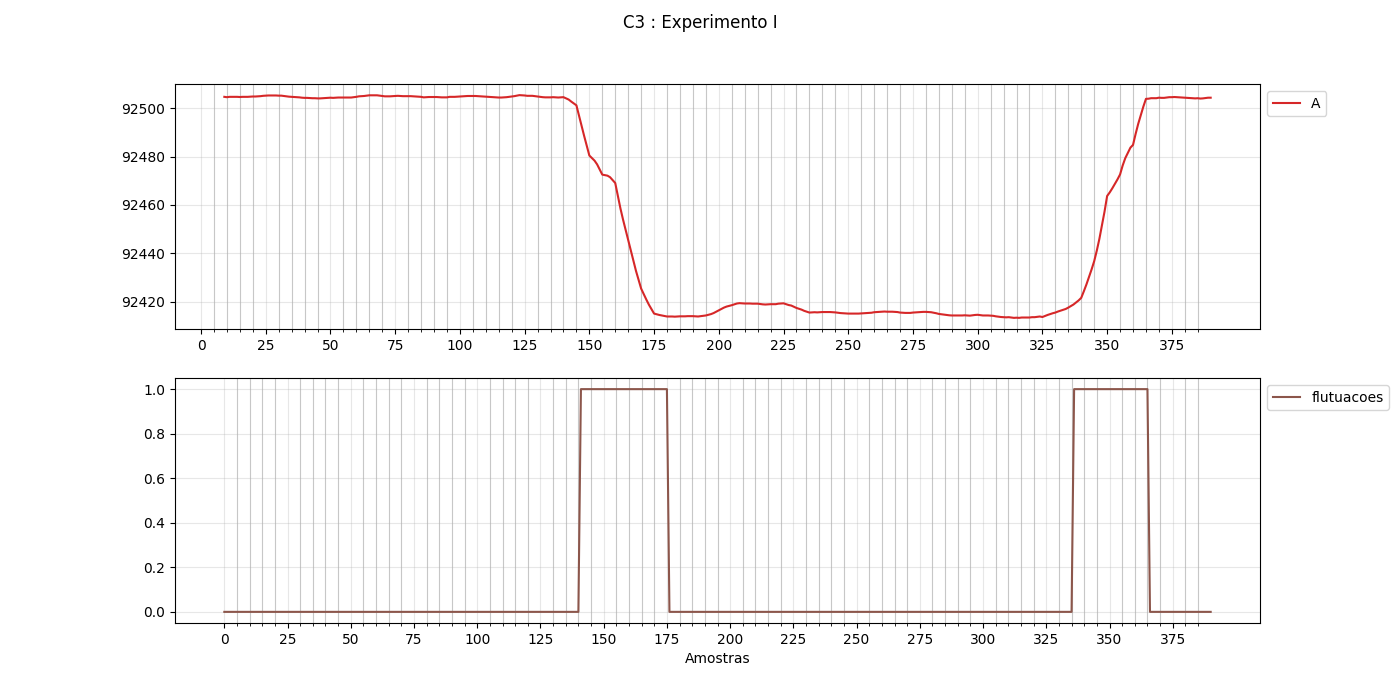

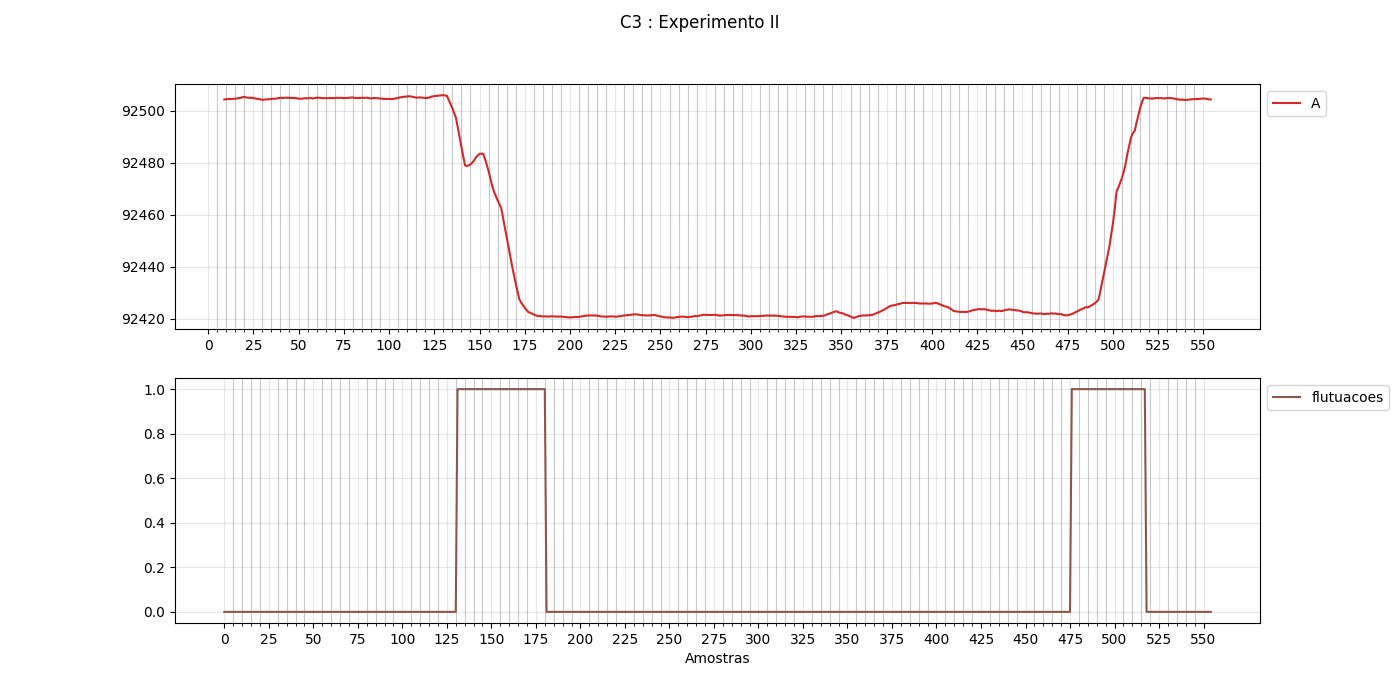

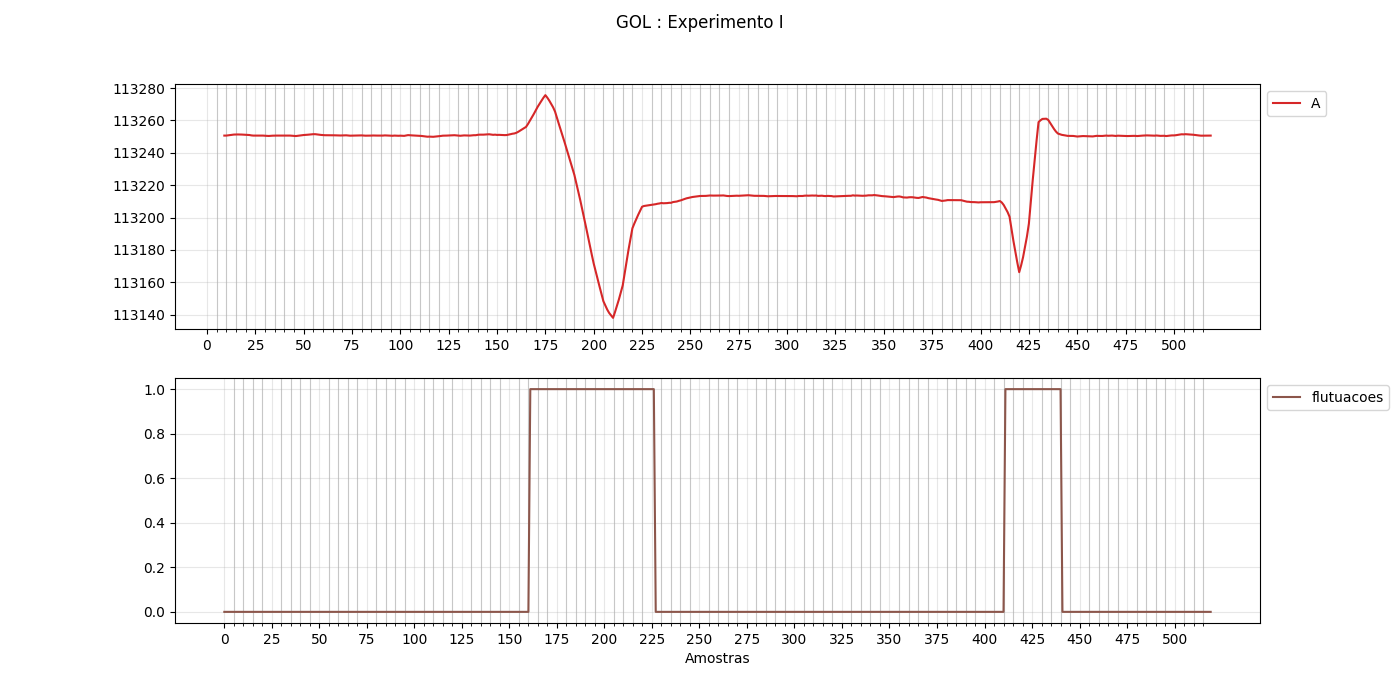

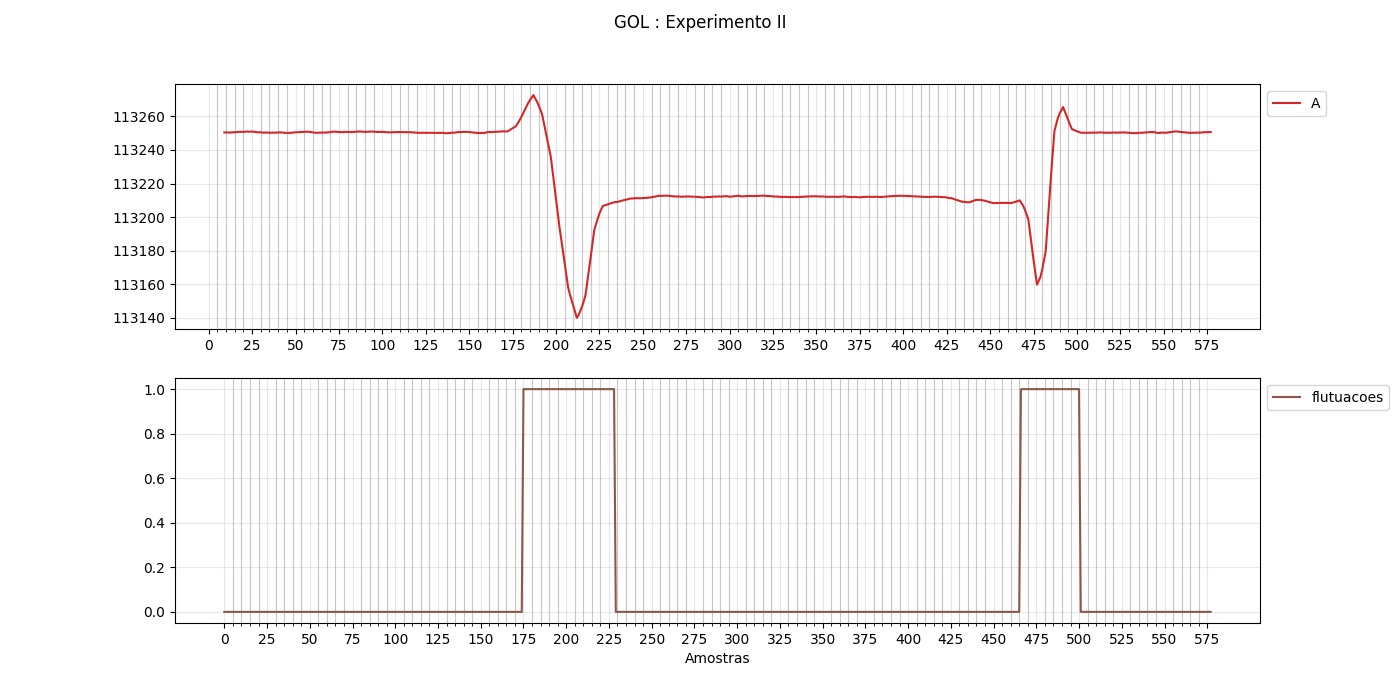

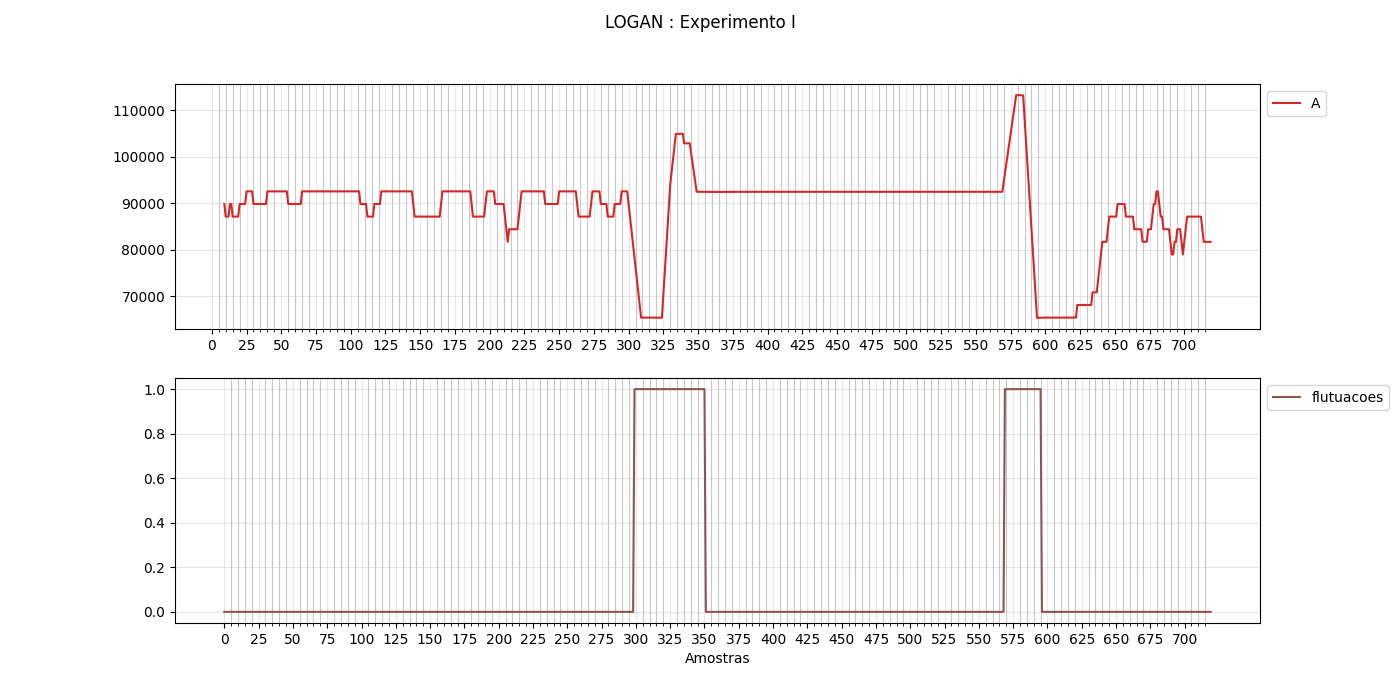

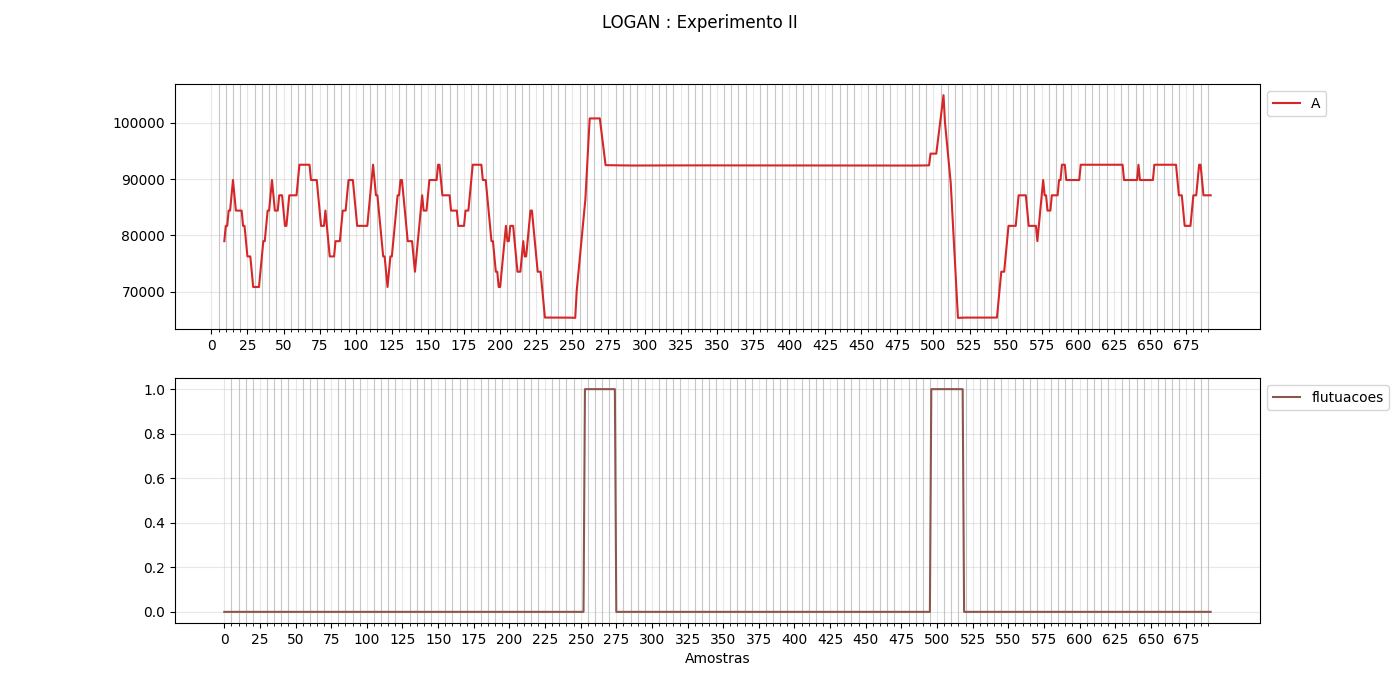

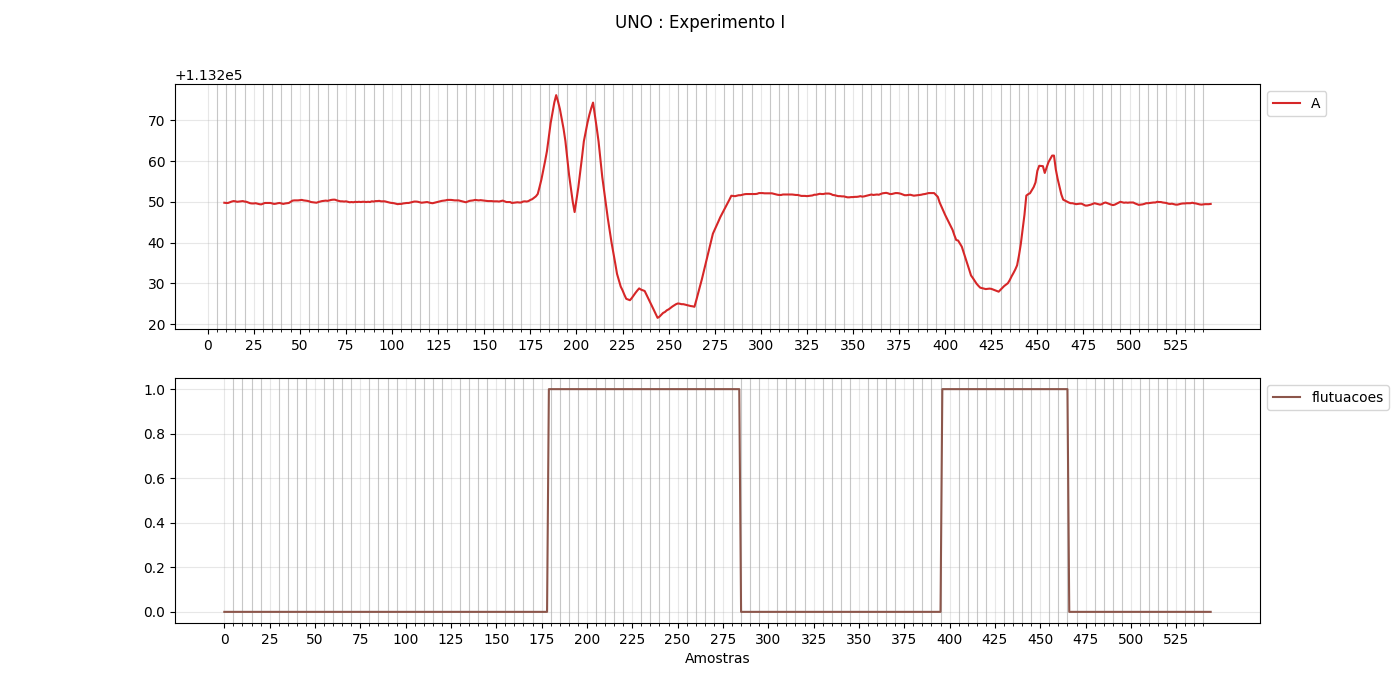

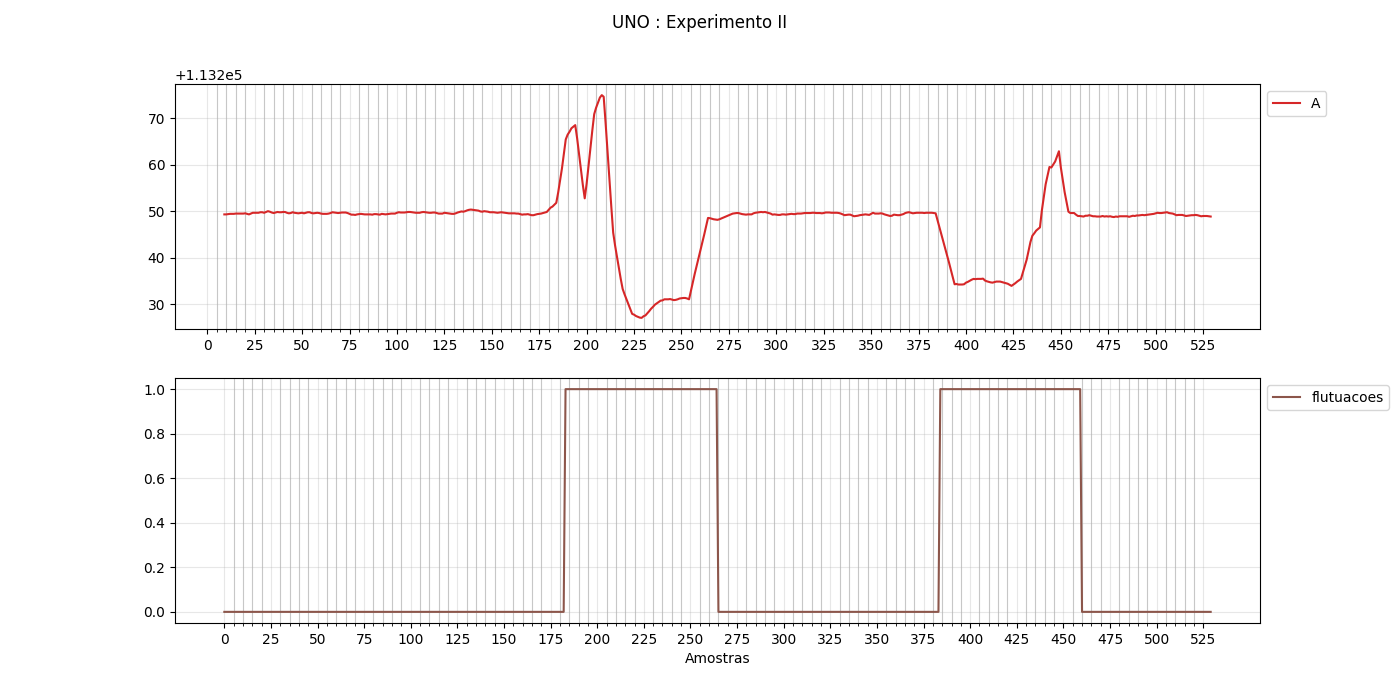

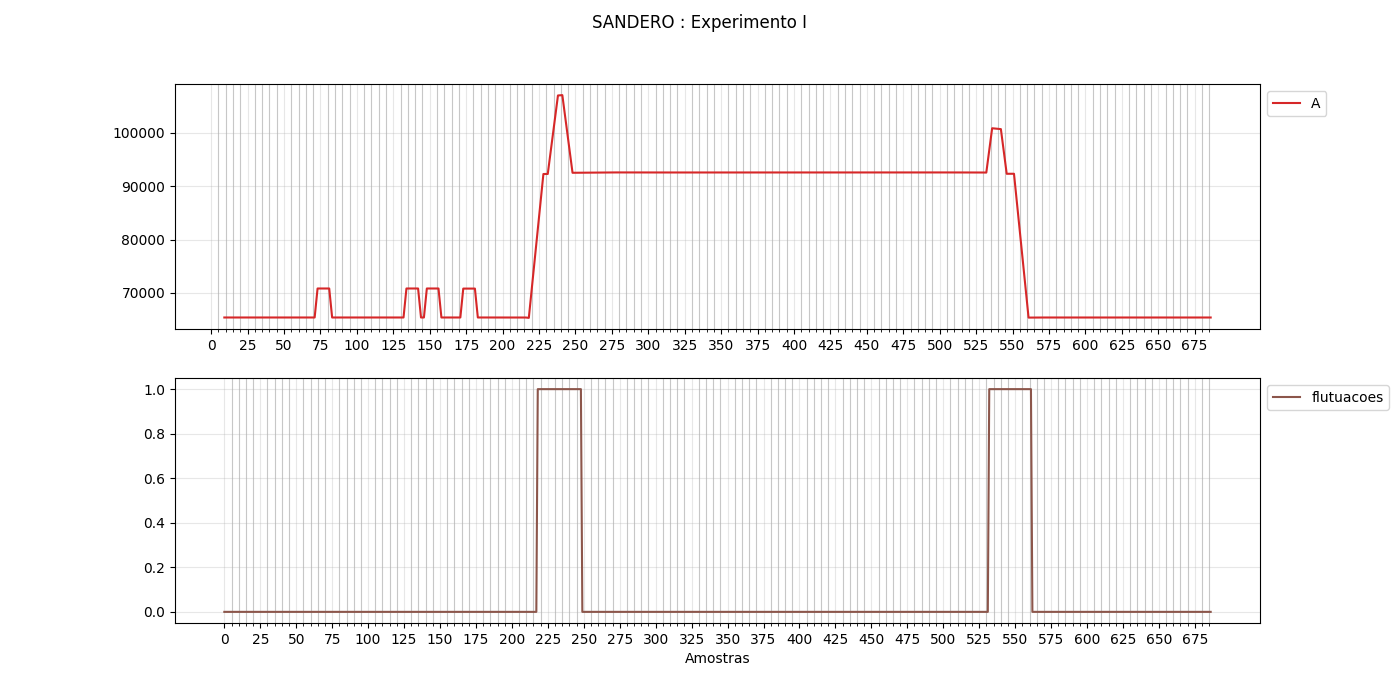

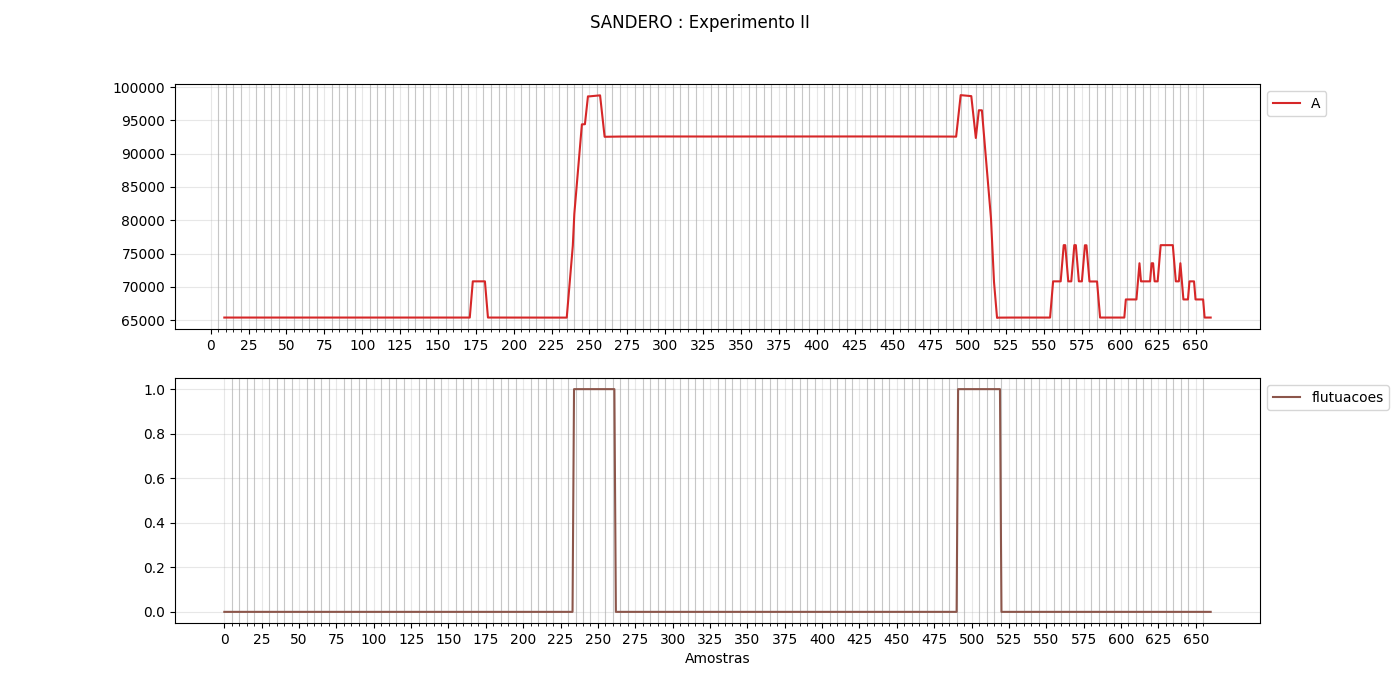

In [21]:
# False para plot de todos experimento
PLOT_ONLY_ONE=False
NO_PLOT=False
configs = [VAR_COLORS['A'], VAR_COLORS['flutuacoes']]
modelos = list(df_all['modelo'].unique())
experimentos = list(df_all['experimento'].unique())
for modelo in modelos:
    for exp in experimentos:
        df = df_all.query(f"modelo=='{modelo}' and experimento=='{exp}'").copy()
        # Comentado para economizar recursos durante testes
        title = f"{modelo} : Experimento {exp}"
        if NO_PLOT==False:
            line_plot_grid(df.copy(), configs=configs,  title=title,  xticks_major=25, xticks_minor=5, path_fig='apendice/C/')
        if PLOT_ONLY_ONE:
            break
    if PLOT_ONLY_ONE:
            break

### Salvar Dataset agrupado

In [22]:
df_all.head()

,i,X,Y,Z,G,A,estado,experimento,modelo,entrando,saindo,flutuacoes
0,0,131,65436,65387,92505.929680,NaN,vazio,I,C3,0,0,0
1,1,130,65434,65385,92503.099845,NaN,vazio,I,C3,0,0,0
2,2,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
3,3,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
4,4,130,65435,65385,92503.807219,NaN,vazio,I,C3,0,0,0


In [23]:
df_all.to_csv('data/all.csv', index=False)

In [24]:
csv2df=pd.read_csv('data/all.csv')

In [25]:
csv2df.head()

,i,X,Y,Z,G,A,estado,experimento,modelo,entrando,saindo,flutuacoes
0,0,131,65436,65387,92505.929680,NaN,vazio,I,C3,0,0,0
1,1,130,65434,65385,92503.099845,NaN,vazio,I,C3,0,0,0
2,2,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
3,3,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
4,4,130,65435,65385,92503.807219,NaN,vazio,I,C3,0,0,0


In [26]:
csv2df.shape

(5880, 12)

## Estatísticas Descritivas / Análise exloratória
---

### Dicionário do dataset transformado

 | Variável    | Tipo    | Descrição         |
 |-------------|---------|-------------------|
 | i           | int64   | número da amostra                  |
 | X           | int64   | Valor do campo magnético no eixo X |
 | Y           | int64   | Valor do campo magnético no eixo Y |
 | Z           | int64   | Valor do campo magnético no eixo Z |
 | G           | float64 | Módulo do vetor x,y,z - *G(i)*      |
 | A           | float64 | Média móvel de G - *A(i)*     |
 | estado      | object  | Estado da vaga       |
 | experimento | object  |Número do experimento |
 | modelo      | object  | Modelo do carro|
 | entrando    | int64   | Flutuação do sinal do carro entrando na vaga - Variável binária 0/1 |
 | saindo      | int64   | Flutuação do sinal do carro saindo na vaga - Variável binária 0/1   |
 | flutuacoes  | int64   | Flutuação entrando e saindo da vaga- Variável binária 0/1   |
 |*Descrição dos tipos* | |**int64**: inteiros positivos; **float64**: reais positivos; **object**: texto |
 

### Variáveis e Dimensões do dataframe

In [27]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5880 entries, 0 to 660
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   i            5880 non-null   int64  
 1   X            5880 non-null   int64  
 2   Y            5880 non-null   int64  
 3   Z            5880 non-null   int64  
 4   G            5880 non-null   float64
 5   A            5790 non-null   float64
 6   estado       5880 non-null   object 
 7   experimento  5880 non-null   object 
 8   modelo       5880 non-null   object 
 9   entrando     5880 non-null   int64  
 10  saindo       5880 non-null   int64  
 11  flutuacoes   5880 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 597.2+ KB


In [28]:
df_all.shape

(5880, 12)

In [29]:
df_all.head()

,i,X,Y,Z,G,A,estado,experimento,modelo,entrando,saindo,flutuacoes
0,0,131,65436,65387,92505.929680,NaN,vazio,I,C3,0,0,0
1,1,130,65434,65385,92503.099845,NaN,vazio,I,C3,0,0,0
2,2,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
3,3,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
4,4,130,65435,65385,92503.807219,NaN,vazio,I,C3,0,0,0


### Estatísticas decritivas dados brutos

In [30]:
df_all[['modelo','experimento','X']].groupby(by=['modelo','experimento']).describe().round(2)

X                                                 \
                     count      mean       std      min      25%      50%   
modelo  experimento                                                         
C3      I            391.0    137.15     10.65    129.0    131.0    136.0   
        II           555.0    127.35     13.44    115.0    118.0    122.0   
GOL     I            520.0  65260.06     24.82  65195.0  65240.0  65271.0   
        II           578.0  65258.42     22.85  65193.0  65241.0  65271.0   
LOGAN   I            720.0  54310.40  24662.84      0.0  65438.0  65485.0   
        II           693.0  48940.37  28460.67      0.0    122.0  65389.0   
SANDERO I            687.0  30611.69  32701.96      0.0      1.0     57.0   
        II           661.0  27554.14  32358.15      0.0      2.0      3.0   
UNO     I            545.0  65270.55     26.14  65239.0  65247.0  65249.0   
        II           530.0  65268.58     24.50  65240.0  65247.0  65248.0   

                                       
                         75%      max  
modelo  experimento                    
C3      I              137.0    182.0  
        II             131.0    186.0  
GOL     I            65272.0  65342.0  
        II           65272.0  65342.0  
LOGAN   I            65535.0  65535.0  
        II           65535.0  65535.0  
SANDERO I            65510.0  65535.0  
        II           65512.0  65535.0  
UNO     I            65290.0  65351.0  
        II           65289.0  65353.0

In [31]:
df_all[['modelo','experimento','Y']].groupby(by=['modelo','experimento']).describe().round(2)

Y                                              \
                     count      mean    std      min      25%      50%   
modelo  experimento                                                      
C3      I            391.0  65400.66  36.76  65359.0  65361.0  65418.0   
        II           555.0  65397.99  30.78  65369.0  65373.0  65375.0   
GOL     I            520.0  65415.91  44.49  65285.0  65392.0  65393.0   
        II           578.0  65420.84  42.72  65284.0  65392.0  65393.0   
LOGAN   I            720.0  65349.11  32.24  65121.0  65333.0  65368.0   
        II           693.0  65355.91  20.84  65243.0  65354.0  65367.0   
SANDERO I            687.0  65396.60  45.29  65045.0  65385.5  65388.0   
        II           661.0  65393.99  36.53  65039.0  65384.0  65385.0   
UNO     I            545.0  65382.46  20.28  65333.0  65375.0  65395.0   
        II           530.0  65380.68  21.30  65335.0  65366.0  65395.0   

                                       
                         75%      max  
modelo  experimento                    
C3      I            65436.0  65456.0  
        II           65435.0  65457.0  
GOL     I            65465.0  65468.0  
        II           65465.0  65468.0  
LOGAN   I            65369.0  65371.0  
        II           65368.0  65370.0  
SANDERO I            65424.0  65438.0  
        II           65417.0  65510.0  
UNO     I            65396.0  65430.0  
        II           65396.0  65432.0

In [32]:
df_all[['modelo','experimento','Z']].groupby(by=['modelo','experimento']).describe().round(2)

Z                                                  \
                     count      mean       std      min       25%      50%   
modelo  experimento                                                          
C3      I            391.0  65358.76     24.51  65329.0  65335.00  65345.0   
        II           555.0  65350.60     24.73  65325.0  65329.00  65336.0   
GOL     I            520.0  65444.81     53.71  65352.0  65385.00  65488.5   
        II           578.0  65438.91     54.70  65357.0  65383.00  65481.0   
LOGAN   I            720.0   2811.50  13071.50     27.0     46.75    111.0   
        II           693.0   2079.41  11208.43      2.0     82.00    112.0   
SANDERO I            687.0   3090.09  13534.70      1.0    122.00    123.0   
        II           661.0   2707.09  12672.37      0.0    122.00    123.0   
UNO     I            545.0  65497.72     16.82  65452.0  65486.00  65510.0   
        II           530.0  65501.18     13.32  65461.0  65492.00  65510.0   

                                       
                         75%      max  
modelo  experimento                    
C3      I            65386.0  65387.0  
        II           65385.0  65388.0  
GOL     I            65492.0  65494.0  
        II           65492.0  65494.0  
LOGAN   I              112.0  65533.0  
        II             112.0  65531.0  
SANDERO I              196.0  65529.0  
        II             194.0  65523.0  
UNO     I            65511.0  65520.0  
        II           65511.0  65518.0

### Estatísticas decritivas por modelo e estado da vaga

In [33]:
from sklearn.preprocessing import MinMaxScaler
scalerMM = MinMaxScaler(feature_range=(-1,1))
df_anaexp = df_all.copy()
df_anaexp.reset_index(inplace=True)
df_anaexp.dropna(inplace=True)

In [34]:
anaexp_list = []
modelos = list(df_anaexp['modelo'].unique())
experimentos = list(df_anaexp['experimento'].unique())
for modelo in modelos:
    for exp in experimentos:
        df = df_anaexp.query(f"modelo=='{modelo}' and experimento=='{exp}'").copy()
        scalerMM.fit(df['A'].values.reshape(-1, 1))
        df['Amin_max'] =scalerMM.transform(df['A'].values.reshape(-1, 1))
        anaexp_list.append(df)
        
df_anaexp = pd.concat(anaexp_list)
df_anaexp.reset_index(inplace=True)
df_anaexp.dropna(inplace=True)

In [35]:
df_anaexp[['estado','Amin_max']].groupby(by=['estado']).describe().round(2)

Amin_max                                         
            count  mean   std  min   25%   50%   75%   max
estado                                                    
entrando    526.0 -0.03  0.68 -1.0 -0.76  0.02  0.62  1.00
ocupado    2057.0 -0.03  0.53 -1.0 -0.06  0.10  0.31  0.63
saindo      392.0 -0.02  0.60 -1.0 -0.63 -0.03  0.48  1.00
vazio      2815.0 -0.05  0.67 -1.0 -0.74  0.02  0.64  1.00

In [36]:
s = df_anaexp['estado']
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'#': counts, 'percent': percent, 'share': percent100})

,#,percent,share
estado,,,
vazio,2815,0.486183,48.6%
ocupado,2057,0.355268,35.5%
entrando,526,0.090846,9.1%
saindo,392,0.067703,6.8%


Amostras sem transformação são maiores porque não foram removidos as 10 amostras de cada experimento que são nula devido a janela de 10 amostras da média móvel

In [37]:
s = df_all['estado']
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'#': counts, 'percent': percent, 'share': percent100})

,#,percent,share
estado,,,
vazio,2905,0.494048,49.4%
ocupado,2057,0.349830,35.0%
entrando,526,0.089456,8.9%
saindo,392,0.066667,6.7%


In [38]:
(0.089456+0.066667)*100

15.612300000000001

In [39]:
df_anaexp[['modelo','estado','A']].groupby(by=['modelo','estado']).describe().round(2)

A                                                        \
                  count       mean       std        min        25%        50%   
modelo  estado                                                                  
C3      entrando   85.0   92464.80     27.40   92415.07   92440.26   92472.12   
        ocupado   455.0   92419.77      3.49   92413.30   92415.81   92420.92   
        saindo     72.0   92454.81     28.95   92418.18   92424.99   92451.88   
        vazio     316.0   92504.74      0.35   92503.96   92504.51   92504.73   
GOL     entrando  120.0  113212.58     46.02  113137.95  113170.80  113207.06   
        ocupado   421.0  113211.81      1.55  113207.29  113211.11  113212.21   
        saindo     65.0  113218.71     35.39  113159.79  113188.29  113209.61   
        vazio     474.0  113250.63      0.35  113249.90  113250.37  113250.65   
LOGAN   entrando   74.0   86173.07  14793.44   65348.80   70307.10   90519.37   
        ocupado   439.0   92452.99     15.79   92416.08   92446.12   92449.09   
        saindo     50.0   94142.45  14041.03   65309.21   89259.56   94639.67   
        vazio     832.0   84897.68   8381.53   65319.40   81685.00   87124.26   
SANDERO entrando   59.0   90785.14  11855.74   65316.88   83903.31   94405.63   
        ocupado   512.0   92584.32      7.70   92532.12   92581.29   92584.48   
        saindo     59.0   90546.01  10205.82   65337.58   86311.10   93788.45   
        vazio     700.0   66511.22   2488.21   65348.99   65384.71   65385.21   
UNO     entrando  188.0  113243.34     16.84  113221.58  113228.31  113238.36   
        ocupado   230.0  113250.51      1.23  113248.15  113249.45  113249.78   
        saindo    146.0  113242.11     10.16  113227.99  113234.47  113239.32   
        vazio     493.0  113249.68      0.41  113248.74  113249.43  113249.66   

                                        
                        75%        max  
modelo  estado                          
C3      entrando   92483.43   92505.81  
        ocupado    92421.69   92426.15  
        saindo     92480.06   92504.88  
        vazio      92504.94   92505.95  
GOL     entrando  113257.69  113275.66  
        ocupado   113212.79  113213.89  
        saindo    113255.09  113265.58  
        vazio     113250.77  113252.38  
LOGAN   entrando  100794.10  104974.08  
        ocupado    92470.87   92485.90  
        saindo    103461.39  113295.63  
        vazio      92562.26   92564.10  
SANDERO entrando   98694.57  107092.29  
        ocupado    92589.07   92596.28  
        saindo     98656.76  100879.69  
        vazio      65387.51   76260.55  
UNO     entrando  113257.33  113276.13  
        ocupado   113251.74  113252.20  
        saindo    113250.10  113262.89  
        vazio     113249.95  113251.34

In [40]:
df_anaexp[['modelo','estado','Amin_max']].groupby(by=['modelo','estado']).describe().round(2)

Amin_max                                          
                    count  mean   std   min   25%   50%   75%   max
modelo  estado                                                     
C3      entrando     85.0  0.07  0.62 -0.97 -0.49  0.26  0.47  1.00
        ocupado     455.0 -0.96  0.04 -1.00 -0.99 -0.97 -0.94 -0.86
        saindo       72.0 -0.16  0.66 -0.97 -0.86 -0.21  0.44  0.98
        vazio       316.0  0.98  0.01  0.96  0.97  0.98  0.98  1.00
GOL     entrando    120.0  0.09  0.68 -1.00 -0.53  0.01  0.75  1.00
        ocupado     421.0  0.08  0.02  0.01  0.07  0.09  0.09  0.10
        saindo       65.0  0.18  0.53 -0.70 -0.27  0.05  0.72  0.89
        vazio       474.0  0.65  0.01  0.63  0.64  0.66  0.67  0.69
LOGAN   entrando     74.0 -0.06  0.67 -1.00 -0.77  0.10  0.57  0.79
        ocupado     439.0  0.25  0.12  0.13  0.13  0.37  0.37  0.37
        saindo       50.0  0.30  0.61 -1.00  0.03  0.47  0.75  1.00
        vazio       832.0 -0.11  0.38 -1.00 -0.20  0.02  0.14  0.38
SANDERO entrando     59.0  0.35  0.63 -1.00 -0.02  0.58  0.89  1.00
        ocupado     512.0  0.45  0.16  0.30  0.31  0.31  0.63  0.63
        saindo       59.0  0.36  0.57 -1.00  0.11  0.54  0.74  1.00
        vazio       700.0 -0.93  0.14 -1.00 -1.00 -1.00 -1.00 -0.35
UNO     entrando    188.0 -0.25  0.65 -1.00 -0.84 -0.45  0.31  1.00
        ocupado     230.0  0.02  0.09 -0.12 -0.07 -0.05  0.11  0.12
        saindo      146.0 -0.31  0.40 -0.76 -0.68 -0.42  0.03  0.50
        vazio       493.0 -0.01  0.05 -0.09 -0.06  0.01  0.04  0.09

In [43]:
df_anaexp[['X','Y','Z','G','A']].corr().round(4)

,X,Y,Z,G,A
X,1.0000,0.0061,0.0655,0.7225,0.6602
Y,0.0061,1.0000,0.2655,0.1856,0.2000
Z,0.0655,0.2655,1.0000,0.7314,0.7407
G,0.7225,0.1856,0.7314,1.0000,0.9572
A,0.6602,0.2000,0.7407,0.9572,1.0000


In [44]:
df_all[['modelo','estado','i']].groupby(by=['modelo','estado']).describe().round(2)

i                                                     
                  count    mean     std    min     25%    50%     75%    max
modelo  estado                                                              
C3      entrando   85.0  156.53   12.96  131.0  146.00  157.0  167.00  180.0
        ocupado   455.0  302.51   81.64  176.0  235.00  292.0  361.50  475.0
        saindo     72.0  435.67   73.30  336.0  353.75  481.5  499.25  517.0
        vazio     334.0  142.72  165.04    0.0   41.25   83.0  124.75  554.0
GOL     entrando  120.0  197.10   18.10  161.0  182.75  197.5  212.25  228.0
        ocupado   421.0  334.54   63.86  227.0  280.00  333.0  385.00  465.0
        saindo     65.0  456.46   30.42  411.0  427.00  468.0  484.00  500.0
        vazio     492.0  218.55  203.33    0.0   61.00  122.5  473.25  577.0
LOGAN   entrando   74.0  306.36   30.99  253.0  271.25  313.5  331.75  350.0
        ocupado   439.0  422.00   73.59  275.0  367.50  422.0  477.00  568.0
        saindo     50.0  547.50   38.47  496.0  508.25  570.5  582.75  595.0
        vazio     850.0  309.78  244.27    0.0  106.00  212.0  599.75  719.0
SANDERO entrando   59.0  239.88   11.30  218.0  232.50  240.0  247.50  261.0
        ocupado   512.0  383.74   75.52  249.0  319.00  383.0  447.00  531.0
        saindo     59.0  526.10   22.62  491.0  505.50  532.0  546.50  561.0
        vazio     718.0  295.41  245.36    0.0   89.25  179.0  583.75  686.0
UNO     entrando  188.0  228.01   28.15  179.0  204.00  227.5  251.00  284.0
        ocupado   230.0  331.72   34.28  265.0  303.25  332.0  360.75  395.0
        saindo    146.0  425.82   21.67  384.0  408.00  426.0  444.00  465.0
        vazio     511.0  209.58  192.05    0.0   63.50  127.0  473.00  544.0

## Modelo por Coeficiênte Angular da Reta
---

### Algoritmo RDP
---

### Funções do Modelo de  RDP

In [45]:
def slope(x1, x2, y1, y2):
        delta_y = y2 - y1
        delta_x = x2 - x1
        return  delta_y/delta_x
    
def slope_abs(x1, x2, y1, y2):
    return  abs(slope(x1, x2, y1, y2))
    
    
def run_rdp(df, start=0, sample_window=50, x_label='i', y_label='A', epsilon=0.5):
    '''
    Tranforma dados iterando o dataframe e executando o algoritmo RDP
    
        Parameters:
                df (dataframe): dataframe com dados
                start (int): amostra inicial
                sample_window (int): tamanho da janela de amostras
                x_label (str): dimensão em x
                y_label (str): dimensão em y para redução RDP
                epsilon (float): limite de tolerância para outliers
        Returns:
                poly_dict (list): lista de dict com pontos reduzidos pelo rdp
    '''
    
    from rdp import rdp
    size = df.shape[0]
    poly = []
    for i in range(start,size,sample_window):
        j= i+sample_window
        if j > size:
            j=size-1
        sample = df[[x_label,y_label]][i:j]
        output = rdp(sample, epsilon=epsilon)
        poly = poly+output
        
    poly_dict = [ dict(zip([x_label,y_label], l)) for l in poly ]
    return poly_dict
    

def apply_slope_model(df, slope_lower_boundary=0.765, slope_upper_boundary=5.49, start=0 , sample_window=5,x_label='i', y_label='A', epsilon=0.5):
    """
    Tranforma dados utilizando o algoritmos RDP(tenho que estudar)
    ??
    """
    df['m']=None
    df['m_abs']=None
    df['pred_flutuacoes']=None
    df['RDP']=None
    poly_points = run_rdp(df, start=0, sample_window=sample_window, x_label=x_label, y_label=y_label, epsilon=0.5)
    size = len(poly_points)
    for i, k in enumerate(poly_points):
        if i >= size-1:
            break
        x1 = k['i']
        x2 = poly_points[i+1]['i']
        y1 = k['A']
        y2 = poly_points[i+1]['A']
        m = slope(x1, x2, y1, y2)
        m_abs = slope_abs(x1, x2, y1, y2)
        m = round(m,2)
        m_abs = round(m_abs,2)
        k['m'] = m
        k['m_abs'] = m_abs
        k['pred_flutuacoes'] = 1 if m_abs >= slope_lower_boundary and m_abs <=slope_upper_boundary else 0
    
    for i, r in enumerate(poly_points):
        try:
            if i >= size-1:
                break
            df.loc[r['i'],'m']=r['m']
            df.loc[r['i'],'m_abs']=r['m_abs']
            df.loc[r['i'],'pred_flutuacoes']=r['pred_flutuacoes']
            df.loc[r['i'],'RDP'] = r['A']
        except Exception as e:
            print(f'Erro no r :{r} causado por {e}')
    return df


#### Avaliação do Modelo

In [46]:
def classification_metrics_report(df_model, y, yp):
    from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,confusion_matrix, classification_report
    cm = {}
    cm['Accuracy']    = accuracy_score(df_model[ y],df_model[yp])
    cm['Recall']      = recall_score(df_model[ y],df_model[yp])
    cm['Precision']   = precision_score(df_model[ y],df_model[yp])
    cm['F1_Score']    = f1_score(df_model[ y],df_model[yp])
    cm['roc_auc']     = roc_auc_score(df_model[ y],df_model[yp])
    cm['confusion_matrix'] = confusion_matrix(df_model[ y],df_model[yp])
    cm['tn'] = cm['confusion_matrix'][0, 0]
    cm['fp'] = cm['confusion_matrix'][0, 1]
    cm['fn'] = cm['confusion_matrix'][1, 0]
    cm['tp'] = cm['confusion_matrix'][1, 1]
    cm['Specificity'] = cm['tn']/(cm['tn']+cm['fp'])
    cm['report']      = classification_report(df_model[ y],df_model[yp],output_dict=True)
    
    return cm

### Funções para rodar o modelo

In [47]:
def run_model(df_all, sample_window, slope_lower_boundary, slope_upper_boundary, epsilon):
    import time
    import datetime
    start_time = time.time()
    y  = 'flutuacoes'
    yp = 'pred_flutuacoes'
    df_list = []
    modelos = list(df_all['modelo'].unique())
    experimentos = list(df_all['experimento'].unique())
    for modelo in modelos:
        for exp in experimentos:
            df = df_all.query(f"modelo=='{modelo}' and experimento=='{exp}'").copy()
            df = apply_slope_model(df, slope_lower_boundary=slope_lower_boundary, slope_upper_boundary=slope_upper_boundary, start=0 , sample_window=sample_window, x_label='i', y_label='A', epsilon=epsilon)
            df_list.append(df)
    df_all_with_model = pd.concat(df_list)
    df_model = df_all_with_model.copy()
    df_model.dropna(inplace=True)
    df_model.reset_index(inplace=True)
    df_model['m_abs'] = df_model['m_abs'].apply(lambda f: float(f))
    df_model['m'] = df_model['m'].apply(lambda f: float(f))
    df_model['RDP'] = df_model['RDP'].apply(lambda f: float(f))
    df_model['pred_flutuacoes'] = df_model['pred_flutuacoes'].apply(lambda f: int(f))
    total_model = df_model.shape[0]
    total_all = df_all.shape[0]
    cm = classification_metrics_report(df_model, y, yp)
    cm['slope_lower_boundary']=slope_lower_boundary
    cm['slope_upper_boundary']=slope_upper_boundary
    cm['sample_window']=sample_window
    cm['epsilon']=epsilon
    cm['total_model']=total_model
    cm['total_all']=total_all
    cm['sample_loss']=1-(total_model/total_all)
    return cm, df_all_with_model, df_model

### Força bruta

In [48]:
def fb_cm(result, index, df_all, sample_window, epsilon, slb, sub):
    import time
    import datetime
    start_time = time.time()
    # print(f'Thread: {index} starded {datetime.datetime.now()}')
    cm, df_all_with_model, df_model  = run_model(df_all, sample_window, slb, sub, epsilon)
    result[index] = cm
    # print(f'Thread: {index} fineshed with time {time.time()-start_time}')

### Otimização de Hiperparâmetros 

#### Definir limites do Coeficiênte angular por regreção de linear

In [49]:
from sklearn.linear_model import LinearRegression
slopes = []
for s in SAMPLE_STATES_BY_A:
    for idx, df in enumerate(s['dfs']):
        modelo=s['car'].upper()
        exp="I"*(idx+1)
        title = f"{modelo} : Experimento {exp}\n"
        # line_plot_grid(df.copy(), configs=configs,  title=title, states=s['states'][idx],  xticks_major=25, xticks_minor=5)
        print("-------------------------------------------------------")
        print(title)
        x1 = s['states'][idx][0]['x']
        x2 = s['states'][idx][1]['x']
        x3 = s['states'][idx][2]['x']
        x4 = s['states'][idx][3]['x']
        
        print(f"Entrando: {x1}:{x2}")
        sample1 = df_all[['i','A','modelo','experimento']].query(f"modelo=='{modelo}' and experimento=='{exp}' and i >= {x1} and i <= {x2}").copy()
        sample1.reset_index(inplace=True)
        sample2 = df_all[['i','A','modelo','experimento']].query(f"modelo=='{modelo}' and experimento=='{exp}' and i >= {x3} and i <= {x4}").copy()
        sample2.reset_index(inplace=True)
        X = sample1['i']
        y = sample1['A']
        model = LinearRegression()
        model.fit(X.values.reshape(-1,1),y)
        cm = slope(sample1['i'][0],sample1['i'].tolist()[-1], sample1['A'][0],sample1['A'].tolist()[-1])
        print(f"LR coef: {model.coef_[0]}")
        print(f"Slope coef: {cm}\n")
        slopes.append({'cm':cm, 'lr':model.coef_[0]})
       
        print(f"Saindo: {x3}:{x4}")
        sample2 = df_all[['i','A','modelo','experimento']].query(f"modelo=='{modelo}' and experimento=='{exp}' and i >= {x3} and i <= {x4}").copy()
        sample2.reset_index(inplace=True)
        X = sample2['i']
        y = sample2['A']
        model = LinearRegression()
        model.fit(X.values.reshape(-1,1),y)
        cm = slope(sample2['i'][0],sample2['i'].tolist()[-1], sample2['A'][0],sample2['A'].tolist()[-1])
        print(f"LR coef: {model.coef_[0]}")
        print(f"Slope coef: {cm}\n")
        
print(slopes)

-------------------------------------------------------
C3 : Experimento I

Entrando: 140:175
LR coef: -2.7050183679258324
Slope coef: -2.557764275140029

Saindo: 335:365
LR coef: 3.113280468270139
Slope coef: 2.87823659380277

-------------------------------------------------------
C3 : Experimento II

Entrando: 130:180
LR coef: -1.7749491397040602
Slope coef: -1.686468929036928

Saindo: 475:517
LR coef: 2.2665893935287666
Slope coef: 1.9890063453480944

-------------------------------------------------------
GOL : Experimento I

Entrando: 160:226
LR coef: -1.9082922697501026
Slope coef: -0.6857867031911596

Saindo: 410:440
LR coef: 2.841506346307945
Slope coef: 1.3912888736401026

-------------------------------------------------------
GOL : Experimento II

Entrando: 174:228
LR coef: -2.2305085784432688
Slope coef: -0.8382159044768842

Saindo: 465:500
LR coef: 2.4246202490017463
Slope coef: 1.1975307032669662

-------------------------------------------------------
LOGAN : Experiment

#### Gerando hiperparâmetros para teste

In [50]:
# size = 25
# epsilon_list = [i/size for i in range(1,size)]
epsilon_list = [0.05,  0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7,0.8, 0.84, 0.88, 0.9, 1]

In [51]:
# slb_list = [round(0.1+i/20,2) for i in range(20)] + [10+i*20 for i in range(10)]
slb_list = [0.1, 0.2, 0.3,  0.4,  0.5,  0.6, 0.7, 0.8, 0.85, 0.9, 1.0,  10, 50, 90, 190, 250]

In [52]:
# sub_list = [3000 -i*100 for i in range(20)]
sub_list = [3000, 2800, 2700, 2600, 2500, 2000,1500, 1100 , 900, 500]

In [53]:
# sample_window_list = [3+i for i in range(20)]
sample_window_list  = [3, 5, 7, 9, 15, 17, 21]

In [54]:
N =len(sub_list)*len(slb_list)*len(sample_window_list)*len(epsilon_list)
print(f"Total de iterações: {N}")

Total de iterações: 14560


In [55]:
params_list=[]
for sw in sample_window_list:
    for slb in slb_list:
        for sub in sub_list:
            for e in epsilon_list:
                params_list.append({'sw':sw, 'e':e, 'slb':slb, 'sub':sub})
print(len(params_list))
print(params_list[0])
print(params_list[-1])

14560
{'sw': 3, 'e': 0.05, 'slb': 0.1, 'sub': 3000}
{'sw': 21, 'e': 1, 'slb': 250, 'sub': 500}


#### Força bruta para definição de de hiperparâmetros

In [57]:
from operator import itemgetter
from threading import Thread
import time
import datetime

####################### WARNING ################
# PROCESSAMENRO EM THREAHS NÃO PODE SER CANCELADO
# VALIDAR ANTES DE EXCUTAR 15K COMBINAÇÕES DEMORA CERCA DE 6 HORAS
chunk_size=1
start=0
end=1
pl = params_list[start:end]
####################### END ################
chunks = np.array_split(pl, int(len(pl)/chunk_size))
N = len(pl)
cm_top100 = []
results = [None] * N
idx=0
for chunk in chunks:
    start_time = time.time()
    idx_s = idx
    print(f'Start chunk idx: {idx} --  {datetime.datetime.now()}')
    threads = [None] * len(chunk)
    for i in range(len(chunk)):
        sw = chunk[i]['sw']
        epsilon = chunk[i]['e']
        slb = chunk[i]['slb']
        sub = chunk[i]['sub']
        threads[i] = Thread(target=fb_cm, args=(results, idx, df_all.copy(), sw, epsilon, slb, sub))
        threads[i].start()
        idx+=1
    
    for i in range(len(threads)):
        threads[i].join()
    top_aux = list(filter(lambda item: item is not None and item['sample_loss'] <= 0.35,results ))
    cm_top100 = cm_top100 +top_aux
    cm_top100 = sorted(cm_top100, key=itemgetter('F1_Score'), reverse=True)
    cm_top100 = cm_top100[0:100]
    print(f'Fineshed chunk : {idx_s}:{idx} fineshed with time {time.time()-start_time}')



Start chunk idx: 0 --  2023-09-27 22:02:20.862695
Fineshed chunk : 0:1 fineshed with time 1.660731315612793


#### Salvando toadas as execuções de hiperparâmetros

In [58]:
import json
# SALVA RESULTADO 
path = f"data/results-geral-{str(datetime.datetime.now())}.json"

with open(path, "w") as outfile:
    outfile.write(str(results))
# path = f"data/1-results-geral-2023-09-23.json"
#TRATA RESULTADO
with open(path, 'r') as openfile:
    str_result = ''.join(openfile.readlines())

str_json_result = str_result.replace('\t', '').replace('\n', '').replace('\'', '"').replace(' ', ' ').replace('array(', '').replace(']])',']]')

#SALVA RESULTADO TRATADO
path_geral = path.replace('geral','geral-tratado')
with open(path_geral, "w") as outfile:
     outfile.write(str_json_result)
    

#### Força bruta para definição de hiperparâmetros sem LOGAN e SANDERO

In [59]:
#validando modelos de veículos
df_all.query("modelo != 'LOGAN' and modelo != 'SANDERO'")['modelo'].unique()

array(['C3', 'GOL', 'UNO'], dtype=object)

In [60]:
from operator import itemgetter
from threading import Thread
import time
import datetime

####################### WARNING ################
# PROCESSAMENRO EM THREAHS NÃO PODE SER CANCELADO
# VALIDAR ANTES DE EXCUTAR 15K COMBINAÇÕES DEMORA CERCA DE 6 HORAS
chunk_size=1
start=0
end=1
pl = params_list[start:end]
####################### E
chunks = np.array_split(pl, int(len(pl)/chunk_size))
N = len(pl)
results = [None] * N
idx=0
# Print the resulting chunksND ################
chunks = np.array_split(pl, int(len(pl)/chunk_size))
N = len(pl)
cm_top100 = []
results = [None] * N
idx=0
for chunk in chunks:
    start_time = time.time()
    idx_s = idx
    print(f'Start chunk idx: {idx} --  {datetime.datetime.now()}')
    threads = [None] * len(chunk)
    for i in range(len(chunk)):
        sw = chunk[i]['sw']
        epsilon = chunk[i]['e']
        slb = chunk[i]['slb']
        sub = chunk[i]['sub']
        threads[i] = Thread(target=fb_cm, args=(results, idx, df_all.query("modelo != 'LOGAN' and modelo != 'SANDERO'").copy(), sw, epsilon, slb, sub))
        threads[i].start()
        idx+=1
    
    for i in range(len(threads)):
        threads[i].join()
    top_aux = list(filter(lambda item: item is not None and item['sample_loss'] <= 0.35,results ))
    cm_top100 = cm_top100 +top_aux
    cm_top100 = sorted(cm_top100, key=itemgetter('F1_Score'), reverse=True)
    cm_top100 = cm_top100[0:100]
    print(f'Fineshed chunk : {idx_s}:{idx} fineshed with time {time.time()-start_time}')



Start chunk idx: 0 --  2023-09-27 22:02:22.555336
Fineshed chunk : 0:1 fineshed with time 0.8669271469116211


#### Salvando execuções de hiperparâmetros sem LOGAN E SANDERO

In [61]:
import json
# SALVA RESULTADO 
path = f"data/results-sem-outiliers-{str(datetime.datetime.now())}.json"
with open(path, "w") as outfile:
    outfile.write(str(results))

#TRATA RESULTADO
with open(path, 'r') as openfile:
    str_result = ''.join(openfile.readlines())

str_json_result = str_result.replace('\t', '').replace('\n', '').replace('\'', '"').replace(' ', ' ').replace('array(', '').replace(']])',']]')

#SALVA RESULTADO TRATADO
path_sem_outliear = path.replace('sem-outiliers','sem-outiliers-tratado')
with open(path_sem_outliear, "w") as outfile:
     outfile.write(str_json_result)
    

#### Recupera hiperparâmetros

In [62]:
####### para utilizar dados gerados em sua execução trocar aquuivos
path_geral='data/1-results-geral-tratado-2023-09-23.json'
path_sem_outliear = 'data/2-results-2023-09-23-sem-outiliers_sandero_logan.json'

In [63]:
with open(path_geral, 'r') as openfile:
    str_geral = ''.join(openfile.readlines())
json_geral = json.loads(str_geral)
results_geral= json_geral['results']

with open(path_sem_outliear, 'r') as openfile:
    str_sem_outliear = ''.join(openfile.readlines())
json_sem_outliear = json.loads(str_sem_outliear)
results_sem_outliear= json_sem_outliear['results']

In [64]:
print(f"type:{type(results_geral)} - {len(results_geral)}")
print(f"type:{type(results_sem_outliear)} - {len(results_sem_outliear)}")

type:<class 'list'> - 14560
type:<class 'list'> - 14560


In [65]:
sorted(results_geral, key=itemgetter('F1_Score'), reverse=True)[0]

{'Accuracy': 0.8877968877968878,
 'Recall': 0.7601476014760148,
 'Precision': 0.7410071942446043,
 'F1_Score': 0.7504553734061931,
 'roc_auc': 0.842179063895902,
 'confusion_matrix': [[878, 72], [65, 206]],
 'tn': 878,
 'fp': 72,
 'fn': 65,
 'tp': 206,
 'Specificity': 0.9242105263157895,
 'report': {'0': {'precision': 0.9310710498409331,
   'recall': 0.9242105263157895,
   'f1-score': 0.9276281035393555,
   'support': 950.0},
  '1': {'precision': 0.7410071942446043,
   'recall': 0.7601476014760148,
   'f1-score': 0.7504553734061931,
   'support': 271.0},
  'accuracy': 0.8877968877968878,
  'macro avg': {'precision': 0.8360391220427688,
   'recall': 0.8421790638959021,
   'f1-score': 0.8390417384727743,
   'support': 1221.0},
  'weighted avg': {'precision': 0.8888865249706588,
   'recall': 0.8877968877968878,
   'f1-score': 0.8883047539356806,
   'support': 1221.0}},
 'slope_lower_boundary': 0.5,
 'slope_upper_boundary': 2700,
 'sample_window': 17,
 'epsilon': 0.05,
 'total_model': 1221

In [66]:
sorted(list(filter(lambda item: item['sample_loss'] < 0.5,results_geral)), key=itemgetter('F1_Score'), reverse=True)[0]

{'Accuracy': 0.904630788485607,
 'Recall': 0.7314814814814815,
 'Precision': 0.6960352422907489,
 'F1_Score': 0.7133182844243792,
 'roc_auc': 0.8348175259214996,
 'confusion_matrix': [[3140, 207], [174, 474]],
 'tn': 3140,
 'fp': 207,
 'fn': 174,
 'tp': 474,
 'Specificity': 0.9381535703615178,
 'report': {'0': {'precision': 0.9474954737477369,
   'recall': 0.9381535703615178,
   'f1-score': 0.9428013811739978,
   'support': 3347.0},
  '1': {'precision': 0.6960352422907489,
   'recall': 0.7314814814814815,
   'f1-score': 0.7133182844243792,
   'support': 648.0},
  'accuracy': 0.904630788485607,
  'macro avg': {'precision': 0.8217653580192429,
   'recall': 0.8348175259214996,
   'f1-score': 0.8280598327991885,
   'support': 3995.0},
  'weighted avg': {'precision': 0.9067079318243007,
   'recall': 0.904630788485607,
   'f1-score': 0.9055785910128581,
   'support': 3995.0}},
 'slope_lower_boundary': 0.5,
 'slope_upper_boundary': 2700,
 'sample_window': 3,
 'epsilon': 0.05,
 'total_model': 

In [67]:
sorted(results_sem_outliear, key=itemgetter('F1_Score'), reverse=True)[0]

{'Accuracy': 0.928944618599791,
 'Recall': 0.7888888888888889,
 'Precision': 0.9508928571428571,
 'F1_Score': 0.8623481781376517,
 'roc_auc': 0.8864386220281416,
 'confusion_matrix': [[676, 11], [57, 213]],
 'tn': 676,
 'fp': 11,
 'fn': 57,
 'tp': 213,
 'Specificity': 0.9839883551673945,
 'report': {'0': {'precision': 0.922237380627558,
   'recall': 0.9839883551673945,
   'f1-score': 0.952112676056338,
   'support': 687.0},
  '1': {'precision': 0.9508928571428571,
   'recall': 0.7888888888888889,
   'f1-score': 0.8623481781376517,
   'support': 270.0},
  'accuracy': 0.928944618599791,
  'macro avg': {'precision': 0.9365651188852075,
   'recall': 0.8864386220281417,
   'f1-score': 0.9072304270969949,
   'support': 957.0},
  'weighted avg': {'precision': 0.9303219978262317,
   'recall': 0.928944618599791,
   'f1-score': 0.9267872691200314,
   'support': 957.0}},
 'slope_lower_boundary': 0.4,
 'slope_upper_boundary': 3000,
 'sample_window': 7,
 'epsilon': 0.05,
 'total_model': 957,
 'tota

In [68]:
sorted(list(filter(lambda item: item['sample_loss'] < 0.5,results_sem_outliear)), key=itemgetter('F1_Score'), reverse=True)[0]

{'Accuracy': 0.936222005842259,
 'Recall': 0.7749469214437368,
 'Precision': 0.9358974358974359,
 'F1_Score': 0.8478513356562137,
 'roc_auc': 0.8795770614799228,
 'confusion_matrix': [[1558, 25], [106, 365]],
 'tn': 1558,
 'fp': 25,
 'fn': 106,
 'tp': 365,
 'Specificity': 0.9842072015161086,
 'report': {'0': {'precision': 0.9362980769230769,
   'recall': 0.9842072015161086,
   'f1-score': 0.9596550662149677,
   'support': 1583.0},
  '1': {'precision': 0.9358974358974359,
   'recall': 0.7749469214437368,
   'f1-score': 0.8478513356562137,
   'support': 471.0},
  'accuracy': 0.936222005842259,
  'macro avg': {'precision': 0.9360977564102564,
   'recall': 0.8795770614799228,
   'f1-score': 0.9037532009355906,
   'support': 2054.0},
  'weighted avg': {'precision': 0.9362062064639353,
   'recall': 0.936222005842259,
   'f1-score': 0.9340175019047567,
   'support': 2054.0}},
 'slope_lower_boundary': 0.4,
 'slope_upper_boundary': 3000,
 'sample_window': 3,
 'epsilon': 0.05,
 'total_model': 20

### Modelo com hiperparâmentros definidos por otimização

### Avaliação do modelo por experimento

In [69]:
def f_text(txt):
    s =' '*(  int((16 - len(txt))/2))
    return f"{s}{txt}{s}"

In [70]:
from sklearn.metrics import classification_report

y  = 'flutuacoes'
yp = 'pred_flutuacoes'
modelos = list(df_all['modelo'].unique())
experimentos = list(df_all['experimento'].unique())
r_modelos = []
exps= []
vars= []
precisions= []
recalls= []
f1_scores= []
supports= []
accuracies = []
slope_lower_boundarys = []
slope_upper_boundarys = []
sample_windows = []
epsilons = []
total_models = []
total_alls = []
sample_losss = []
criterios =[]

params = [
    {'sw':17, 'slb' :0.5, 'sub':2700, 'epsilon':0.05, 'criterio':'A - geral'},
    {'sw':3,  'slb' :0.5, 'sub':2700, 'epsilon':0.05, 'criterio':'B - geral - sl < 0.5'},
    {'sw':7,  'slb' :0.4, 'sub':3000, 'epsilon':0.05, 'criterio':'C - sem sandero e logan'},
    {'sw':3,  'slb' :0.4, 'sub':3000, 'epsilon':0.05, 'criterio':'D - sem sandero e logan - sl < 0.5'},
 ]
for p in params:
    for modelo in modelos:
        for exp in experimentos:
            df = df_all.query(f"modelo=='{modelo}' and experimento=='{exp}'").copy()
            cm_exp, df_exp, df_m = run_model(df, p['sw'], p['slb'], p['sub'], p['epsilon'])
            
            for b in ['0','1','macro avg','weighted avg']:
                precision = cm_exp['report'][b]['precision']
                recall    = cm_exp['report'][b]['recall']
                f1_score  = cm_exp['report'][b]['f1-score']
                support   = cm_exp['report'][b]['support']
                r_modelos.append(modelo)
                exps.append(exp)
                vars.append(b)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1_score)
                supports.append(support)
                accuracies.append(cm_exp['report']['accuracy'])
                slope_lower_boundarys.append(cm_exp['slope_lower_boundary'])
                slope_upper_boundarys.append(cm_exp['slope_upper_boundary'])
                sample_windows.append(cm_exp['sample_window'])
                epsilons.append(cm_exp['epsilon'])
                total_models.append(cm_exp['total_model'])
                total_alls.append(cm_exp['total_all'])
                sample_losss.append(cm_exp['sample_loss'])
                criterios.append(p['criterio'])
            # print(cm_exp['report'])
    # break
dfm = pd.DataFrame({
                    'modelo': r_modelos, 
                    'experimento': exps, 
                    'contexto':vars,
                    'precision': precisions,
                    'recall':recalls,
                    'f1-score':f1_scores,
                    'support': supports,
                    'accurracy':accuracies,
                    'slb':slope_lower_boundarys,
                    'sub':slope_upper_boundarys,
                    'sample_window':sample_windows,
                    'epsilon':epsilons,
                    'size_model':total_models,
                    'size_all':total_alls,
                    'sample_loss':sample_losss,
                    'criterio':criterios, 
                   })


In [71]:
list(dfm['criterio'].unique())

['A - geral',
 'B - geral - sl < 0.5',
 'C - sem sandero e logan',
 'D - sem sandero e logan - sl < 0.5']

In [72]:
import dataframe_image as dfi
# display.max_columns
# max_colwidth
# max_rows and min_rows
# max_seq_items  
pd.set_option('display.max_rows', 200)
criterios = list(dfm['criterio'].unique())
for criterio in criterios:
    dfi.export(dfm.query(f'criterio=="{criterio}"').copy(), f"apendice/D/{criterio.replace(' ', '_').replace('<', '_').replace(',', '_')}.png")

In [73]:
dfm.query('contexto=="weighted avg"').head()

,modelo,experimento,contexto,precision,recall,f1-score,support,accurracy,slb,sub,sample_window,epsilon,size_model,size_all,sample_loss,criterio
3,C3,I,weighted avg,0.924629,0.925373,0.924749,67.0,0.925373,0.5,2700,17,0.05,67,391,0.828645,A - geral
7,C3,II,weighted avg,0.947891,0.943820,0.941755,89.0,0.943820,0.5,2700,17,0.05,89,555,0.839640,A - geral
11,GOL,I,weighted avg,0.954023,0.954023,0.954023,87.0,0.954023,0.5,2700,17,0.05,87,520,0.832692,A - geral
15,GOL,II,weighted avg,0.968009,0.968085,0.967915,94.0,0.968085,0.5,2700,17,0.05,94,578,0.837370,A - geral
19,LOGAN,I,weighted avg,0.886083,0.853403,0.865854,191.0,0.853403,0.5,2700,17,0.05,191,720,0.734722,A - geral


In [74]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   modelo         160 non-null    object 
 1   experimento    160 non-null    object 
 2   contexto       160 non-null    object 
 3   precision      160 non-null    float64
 4   recall         160 non-null    float64
 5   f1-score       160 non-null    float64
 6   support        160 non-null    float64
 7   accurracy      160 non-null    float64
 8   slb            160 non-null    float64
 9   sub            160 non-null    int64  
 10  sample_window  160 non-null    int64  
 11  epsilon        160 non-null    float64
 12  size_model     160 non-null    int64  
 13  size_all       160 non-null    int64  
 14  sample_loss    160 non-null    float64
 15  criterio       160 non-null    object 
dtypes: float64(8), int64(4), object(4)
memory usage: 20.1+ KB


In [75]:
dfm[[
    'criterio', 
    'modelo', 
    'experimento', 
    'contexto',
    'accurracy',
    'f1-score',
    'precision',
    'recall',
    'support',
    'sample_loss',
    'size_model',
    'size_all',                    
]].query('contexto=="weighted avg"')[[
    'criterio', 
    'modelo', 
    'accurracy',
    'f1-score',
    'precision',
    'recall',
    'support',
    'sample_loss'
]].groupby(by=['modelo','criterio']).mean().round(2)

accurracy  f1-score  precision  \
modelo  criterio                                                             
C3      A - geral                                0.93      0.93       0.94   
        B - geral - sl < 0.5                     0.96      0.96       0.96   
        C - sem sandero e logan                  0.95      0.95       0.95   
        D - sem sandero e logan - sl < 0.5       0.95      0.95       0.95   
GOL     A - geral                                0.96      0.96       0.96   
        B - geral - sl < 0.5                     0.98      0.98       0.98   
        C - sem sandero e logan                  0.97      0.97       0.97   
        D - sem sandero e logan - sl < 0.5       0.98      0.98       0.98   
LOGAN   A - geral                                0.86      0.87       0.89   
        B - geral - sl < 0.5                     0.84      0.86       0.89   
        C - sem sandero e logan                  0.62      0.70       0.89   
        D - sem sandero e logan - sl < 0.5       0.67      0.74       0.89   
SANDERO A - geral                                0.89      0.90       0.92   
        B - geral - sl < 0.5                     0.90      0.91       0.94   
        C - sem sandero e logan                  0.82      0.85       0.92   
        D - sem sandero e logan - sl < 0.5       0.85      0.87       0.94   
UNO     A - geral                                0.83      0.82       0.87   
        B - geral - sl < 0.5                     0.87      0.86       0.89   
        C - sem sandero e logan                  0.87      0.86       0.89   
        D - sem sandero e logan - sl < 0.5       0.88      0.87       0.89   

                                            recall  support  sample_loss  
modelo  criterio                                                          
C3      A - geral                             0.93     78.0         0.83  
        B - geral - sl < 0.5                  0.96    311.0         0.34  
        C - sem sandero e logan               0.95    144.0         0.70  
        D - sem sandero e logan - sl < 0.5    0.95    311.0         0.34  
GOL     A - geral                             0.96     90.5         0.84  
        B - geral - sl < 0.5                  0.98    360.5         0.34  
        C - sem sandero e logan               0.97    167.0         0.70  
        D - sem sandero e logan - sl < 0.5    0.98    360.5         0.34  
LOGAN   A - geral                             0.86    212.5         0.70  
        B - geral - sl < 0.5                  0.84    514.0         0.27  
        C - sem sandero e logan               0.62    300.5         0.57  
        D - sem sandero e logan - sl < 0.5    0.67    514.0         0.27  
SANDERO A - geral                             0.89    139.5         0.79  
        B - geral - sl < 0.5                  0.90    456.5         0.32  
        C - sem sandero e logan               0.82    231.0         0.66  
        D - sem sandero e logan - sl < 0.5    0.85    456.5         0.32  
UNO     A - geral                             0.83     90.0         0.83  
        B - geral - sl < 0.5                  0.87    355.5         0.34  
        C - sem sandero e logan               0.87    167.5         0.69  
        D - sem sandero e logan - sl < 0.5    0.88    355.5         0.34

In [76]:
dfm[[
    'criterio', 
    'modelo', 
    'experimento', 
    'contexto',
    'accurracy',
    'f1-score',
    'precision',
    'recall',
    'support',
    'sample_loss',
    'size_model',
    'size_all',                    
]].query('contexto=="weighted avg"')[[
    'criterio', 
    'modelo', 
    'accurracy',
    'f1-score',
    'precision',
    'recall',
    'support',
    'sample_loss'
]].groupby(by=['criterio','modelo']).mean().round(2)

accurracy  f1-score  precision  \
criterio                           modelo                                    
A - geral                          C3            0.93      0.93       0.94   
                                   GOL           0.96      0.96       0.96   
                                   LOGAN         0.86      0.87       0.89   
                                   SANDERO       0.89      0.90       0.92   
                                   UNO           0.83      0.82       0.87   
B - geral - sl < 0.5               C3            0.96      0.96       0.96   
                                   GOL           0.98      0.98       0.98   
                                   LOGAN         0.84      0.86       0.89   
                                   SANDERO       0.90      0.91       0.94   
                                   UNO           0.87      0.86       0.89   
C - sem sandero e logan            C3            0.95      0.95       0.95   
                                   GOL           0.97      0.97       0.97   
                                   LOGAN         0.62      0.70       0.89   
                                   SANDERO       0.82      0.85       0.92   
                                   UNO           0.87      0.86       0.89   
D - sem sandero e logan - sl < 0.5 C3            0.95      0.95       0.95   
                                   GOL           0.98      0.98       0.98   
                                   LOGAN         0.67      0.74       0.89   
                                   SANDERO       0.85      0.87       0.94   
                                   UNO           0.88      0.87       0.89   

                                            recall  support  sample_loss  
criterio                           modelo                                 
A - geral                          C3         0.93     78.0         0.83  
                                   GOL        0.96     90.5         0.84  
                                   LOGAN      0.86    212.5         0.70  
                                   SANDERO    0.89    139.5         0.79  
                                   UNO        0.83     90.0         0.83  
B - geral - sl < 0.5               C3         0.96    311.0         0.34  
                                   GOL        0.98    360.5         0.34  
                                   LOGAN      0.84    514.0         0.27  
                                   SANDERO    0.90    456.5         0.32  
                                   UNO        0.87    355.5         0.34  
C - sem sandero e logan            C3         0.95    144.0         0.70  
                                   GOL        0.97    167.0         0.70  
                                   LOGAN      0.62    300.5         0.57  
                                   SANDERO    0.82    231.0         0.66  
                                   UNO        0.87    167.5         0.69  
D - sem sandero e logan - sl < 0.5 C3         0.95    311.0         0.34  
                                   GOL        0.98    360.5         0.34  
                                   LOGAN      0.67    514.0         0.27  
                                   SANDERO    0.85    456.5         0.32  
                                   UNO        0.88    355.5         0.34

In [77]:
dfm[[
    'criterio', 
    'modelo', 
    'experimento', 
    'contexto',
    'accurracy',
    'f1-score',
    'precision',
    'recall',
    'support',
    'sample_loss',
    'size_model',
    'size_all',                    
]].query('contexto=="weighted avg"')[[
    'criterio', 
    'accurracy',
    'f1-score',
    'precision',
    'recall',
    'support',
    'sample_loss'
]].groupby(by=['criterio']).mean().round(2)

,accurracy,f1-score,precision,recall,support,sample_loss
criterio,,,,,,
A - geral,0.89,0.90,0.92,0.89,122.1,0.80
B - geral - sl < 0.5,0.91,0.92,0.93,0.91,399.5,0.32
C - sem sandero e logan,0.85,0.86,0.92,0.85,202.0,0.66
D - sem sandero e logan - sl < 0.5,0.87,0.88,0.93,0.87,399.5,0.32


#### Plot modelos

In [78]:
df_all.head()

,i,X,Y,Z,G,A,estado,experimento,modelo,entrando,saindo,flutuacoes
0,0,131,65436,65387,92505.929680,NaN,vazio,I,C3,0,0,0
1,1,130,65434,65385,92503.099845,NaN,vazio,I,C3,0,0,0
2,2,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
3,3,131,65436,65386,92505.222842,NaN,vazio,I,C3,0,0,0
4,4,130,65435,65385,92503.807219,NaN,vazio,I,C3,0,0,0


In [79]:
df_all.shape

(5880, 12)

In [80]:
cm_exp, df_exps, df_m = run_model(df_all, 3, 0.5, 2700, 0.05)

In [81]:

# False para plot de todos experimento

PLOT_ONLY_ONE=True
NOT_PLOT=True
configs = [VAR_COLORS['A'], VAR_COLORS['RDP'], VAR_COLORS['m'], VAR_COLORS['m_abs'], VAR_COLORS['flutuacoes'],VAR_COLORS['pred_flutuacoes']]
modelos = list(df_exps['modelo'].unique())
experimentos = list(df_exps['experimento'].unique())
for modelo in modelos:
    for exp in experimentos:
        df = df_exps.query(f"modelo=='{modelo}' and experimento=='{exp}'").copy()
        title = f"{modelo} : Experimento {exp}"
        if not NOT_PLOT:
            # line_plot_grid(df.copy(), configs=configs,  title=title,  xticks_major=25, xticks_minor=5,path_fig='apendice/E/')
            line_plot_grid(df.copy(), configs=configs,  title=title,  xticks_major=25, xticks_minor=5)
        if PLOT_ONLY_ONE:
            break
    if PLOT_ONLY_ONE:
            break

#### PLOT COM REMOÇÂO DE AMOTRAS DEFINIDAS PELO RDP

In [82]:

# False para plot de todos experimento

PLOT_ONLY_ONE=True
NOT_PLOT=True
configs = [VAR_COLORS['A'], VAR_COLORS['RDP'], VAR_COLORS['m_abs'], VAR_COLORS['flutuacoes'],VAR_COLORS['pred_flutuacoes']]
modelos = list(df_m['modelo'].unique())
experimentos = list(df_m['experimento'].unique())
for modelo in modelos:
    for exp in experimentos:
        df = df_m.query(f"modelo=='{modelo}' and experimento=='{exp}'").copy()
        title = f"{modelo} : Experimento {exp}"
        if not NOT_PLOT:
            line_plot_grid(df.copy(), configs=configs,  title=title,  xticks_major=25, xticks_minor=5,path_fig='apendice/F/')
        if PLOT_ONLY_ONE:
            break
    if PLOT_ONLY_ONE:
            break